In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    #err_ind=[]
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6), bwidth=1)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])


        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator = adap.PoissonEstimator(MP,uh,f)
            err_est[iter] = norm(err_indicator)
            marked_patches = adap.doerfler_marking(err_indicator, theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            print("")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6),bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
            
        if iter < maxiter-1:
            start=time.time()
            M.refine()
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0.

0


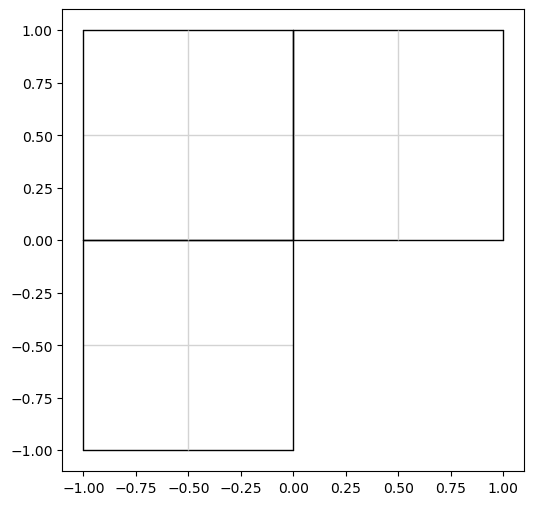

Refinement took 0.00013756752014160156 seconds.
1


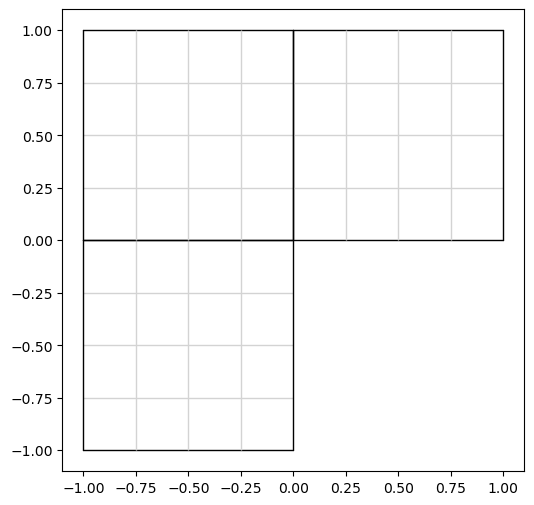

Refinement took 0.0001468658447265625 seconds.
2


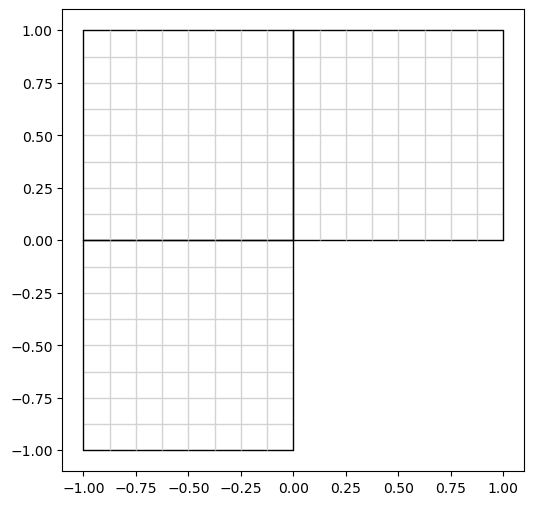

Refinement took 0.00014591217041015625 seconds.
3


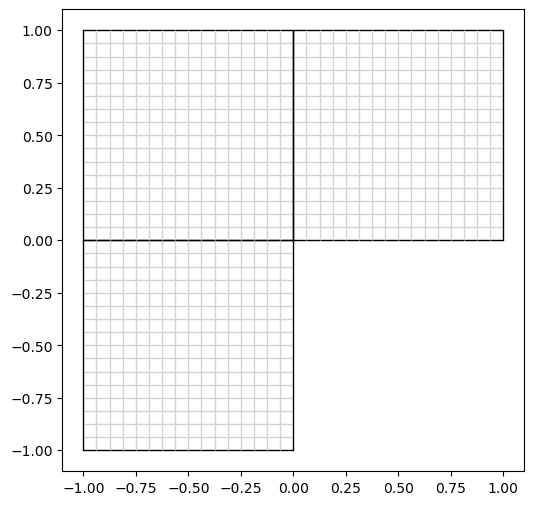

Refinement took 0.0001494884490966797 seconds.
4


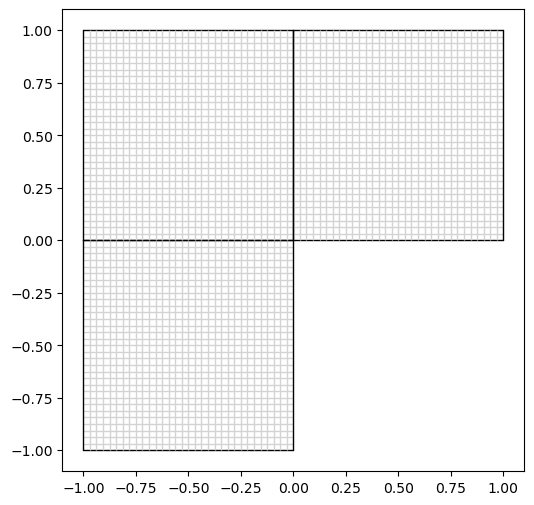

Refinement took 0.0001537799835205078 seconds.
5


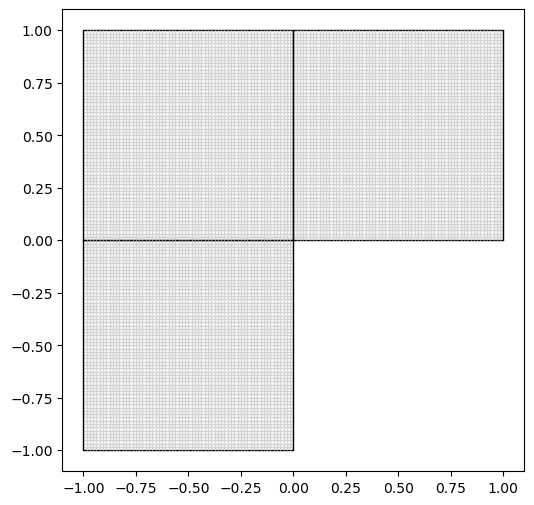

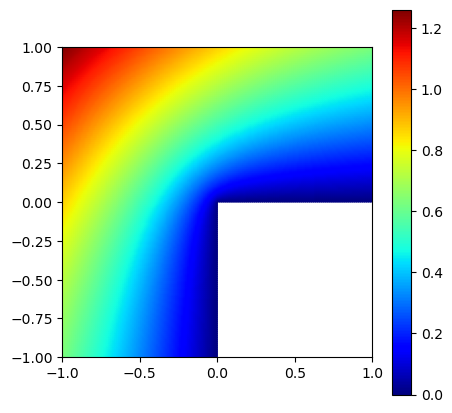

In [7]:
deg=1
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=6, draw=True)
# M.draw()

0


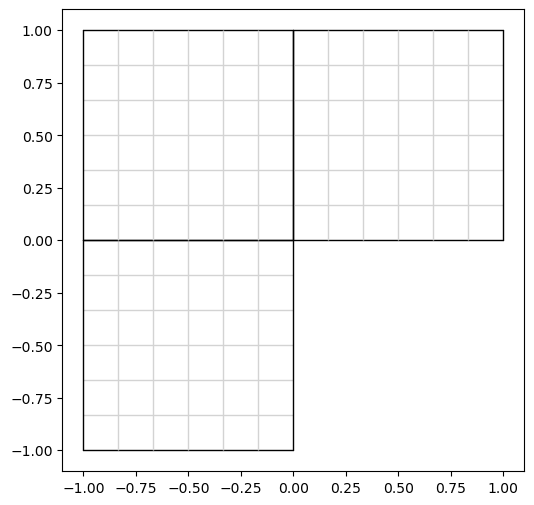

Residual contributions took 0.01965928077697754 seconds.
Jump contributions took 0.010306596755981445 seconds.
Estimate and Marking took 0.030112504959106445 seconds.
Refinement took 0.008134841918945312 seconds.

1


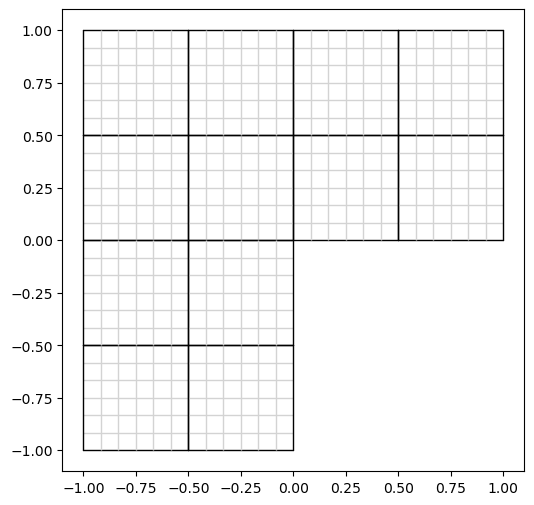

Residual contributions took 0.0735158920288086 seconds.
Jump contributions took 0.08270120620727539 seconds.
Estimate and Marking took 0.15636587142944336 seconds.
Refinement took 0.009693384170532227 seconds.

2


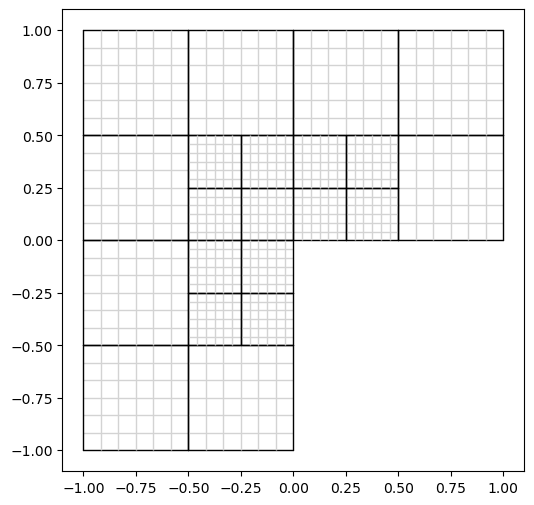

Residual contributions took 0.13197684288024902 seconds.
Jump contributions took 0.19127345085144043 seconds.
Estimate and Marking took 0.32341837882995605 seconds.
Refinement took 0.014064550399780273 seconds.

3


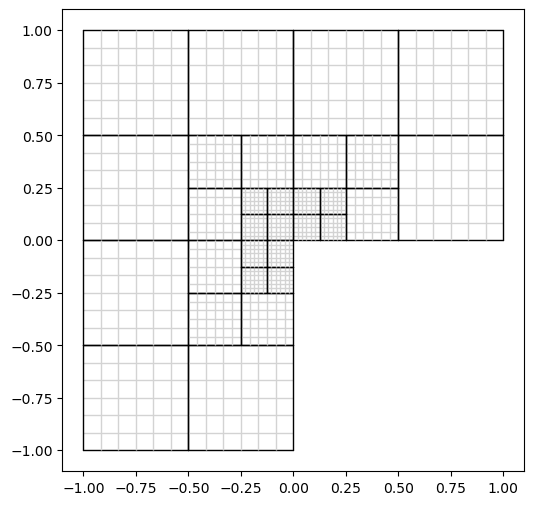

Residual contributions took 0.18605732917785645 seconds.
Jump contributions took 0.31298398971557617 seconds.
Estimate and Marking took 0.4993565082550049 seconds.
Refinement took 0.01413869857788086 seconds.

4


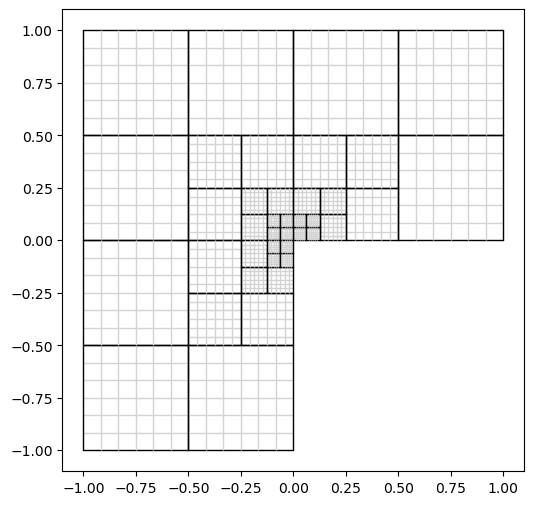

Residual contributions took 0.23897933959960938 seconds.
Jump contributions took 0.4172956943511963 seconds.
Estimate and Marking took 0.656508207321167 seconds.
Refinement took 0.01580524444580078 seconds.

5


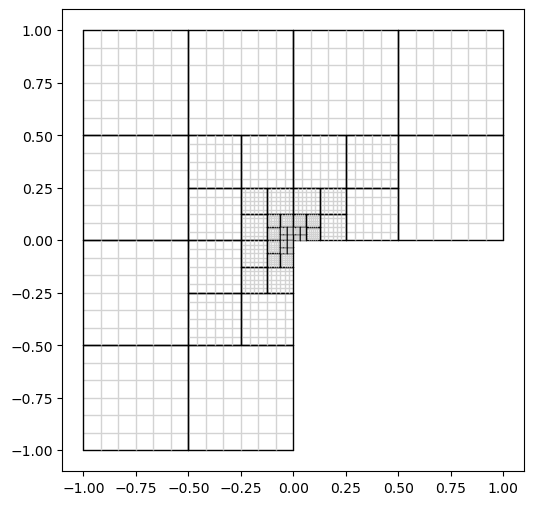

Residual contributions took 0.28862810134887695 seconds.
Jump contributions took 0.5392420291900635 seconds.
Estimate and Marking took 0.828399658203125 seconds.
Refinement took 0.01753997802734375 seconds.

6


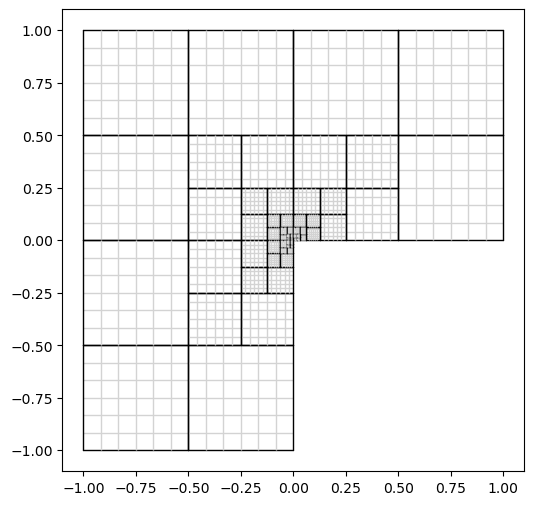

Residual contributions took 0.3441910743713379 seconds.
Jump contributions took 0.6483309268951416 seconds.
Estimate and Marking took 0.9927821159362793 seconds.
Refinement took 0.0195620059967041 seconds.

7


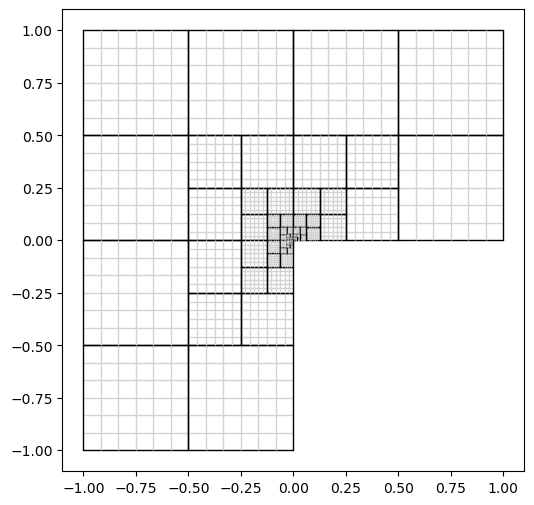

Residual contributions took 0.3946342468261719 seconds.
Jump contributions took 0.7498443126678467 seconds.
Estimate and Marking took 1.1447744369506836 seconds.
Refinement took 0.021234750747680664 seconds.

8


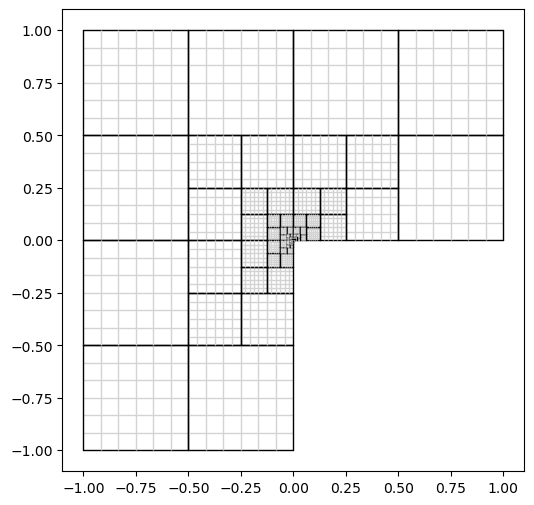

Residual contributions took 0.44846653938293457 seconds.
Jump contributions took 0.876431941986084 seconds.
Estimate and Marking took 1.325186014175415 seconds.
Refinement took 0.023262977600097656 seconds.

9


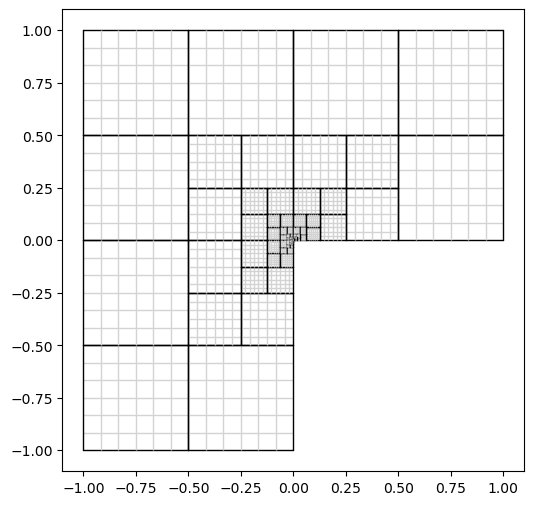

Residual contributions took 0.5131652355194092 seconds.
Jump contributions took 0.9692845344543457 seconds.
Estimate and Marking took 1.4827942848205566 seconds.
Refinement took 0.030675888061523438 seconds.

10


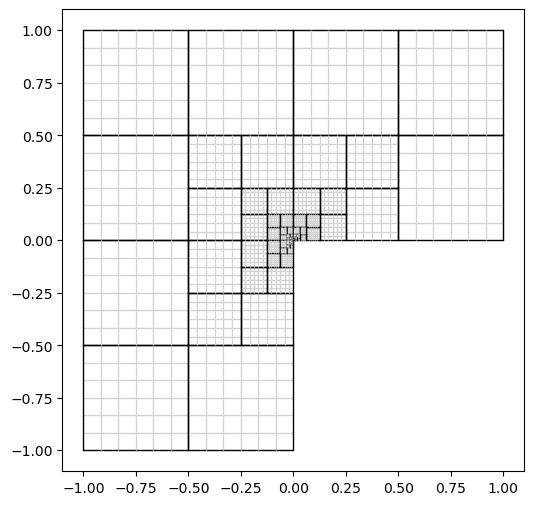

Residual contributions took 0.5577089786529541 seconds.
Jump contributions took 1.0919172763824463 seconds.
Estimate and Marking took 1.6502234935760498 seconds.
Refinement took 0.02654719352722168 seconds.

11


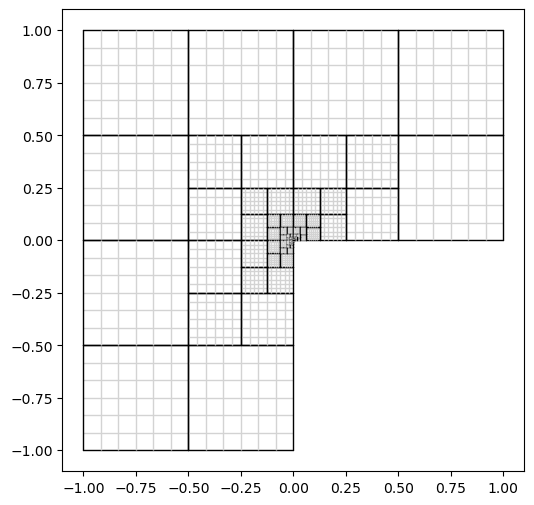

Residual contributions took 0.6119766235351562 seconds.
Jump contributions took 1.1982433795928955 seconds.
Estimate and Marking took 1.810514211654663 seconds.
Refinement took 0.02864551544189453 seconds.

12


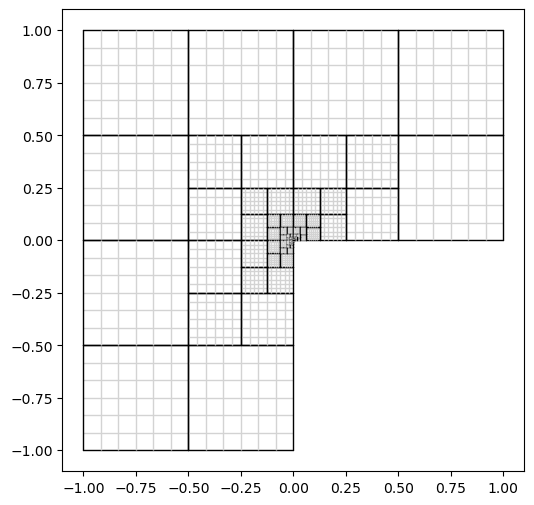

Residual contributions took 0.702603816986084 seconds.
Jump contributions took 1.3202710151672363 seconds.
Estimate and Marking took 2.0232179164886475 seconds.
Refinement took 0.03234672546386719 seconds.

13


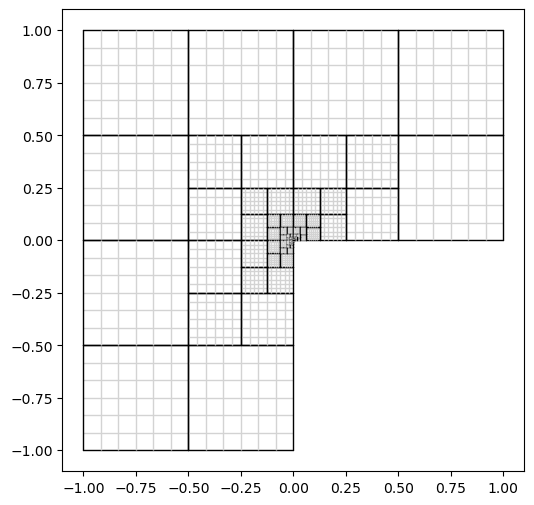

Residual contributions took 0.848299503326416 seconds.
Jump contributions took 1.5039763450622559 seconds.
Estimate and Marking took 2.3528521060943604 seconds.
Refinement took 0.035808563232421875 seconds.

14


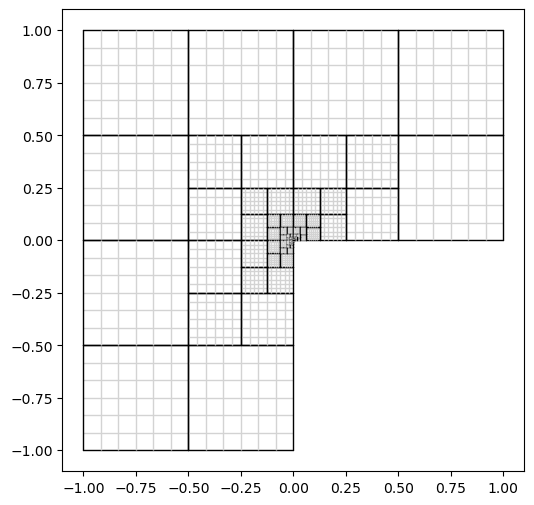

Residual contributions took 0.8093574047088623 seconds.
Jump contributions took 1.5374693870544434 seconds.
Estimate and Marking took 2.3474557399749756 seconds.
Refinement took 0.033696889877319336 seconds.

15


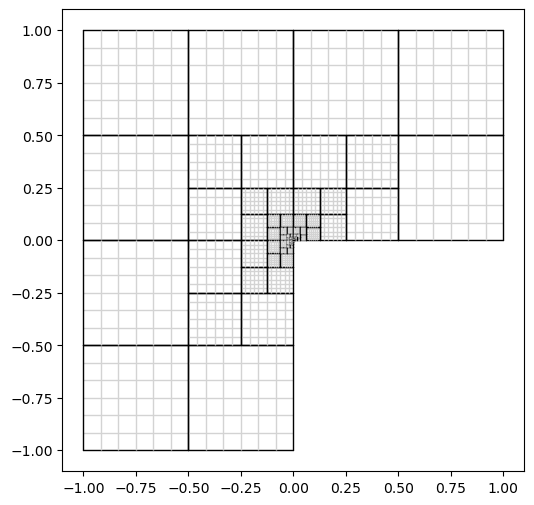

Residual contributions took 0.8345179557800293 seconds.
Jump contributions took 1.6361181735992432 seconds.
Estimate and Marking took 2.4709746837615967 seconds.
Refinement took 0.03581714630126953 seconds.

16


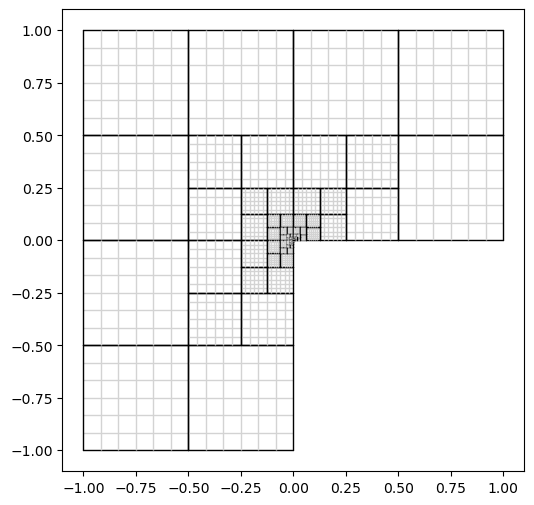

Residual contributions took 0.8793282508850098 seconds.
Jump contributions took 1.750946283340454 seconds.
Estimate and Marking took 2.630784511566162 seconds.
Refinement took 0.037615299224853516 seconds.

17


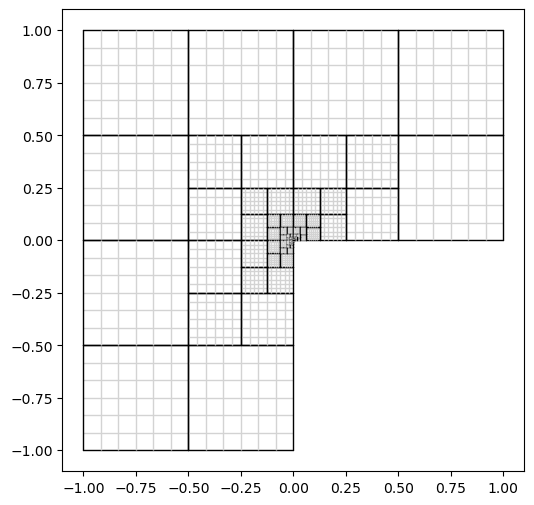

Residual contributions took 0.9371111392974854 seconds.
Jump contributions took 1.871877670288086 seconds.
Estimate and Marking took 2.8093247413635254 seconds.
Refinement took 0.03988027572631836 seconds.

18


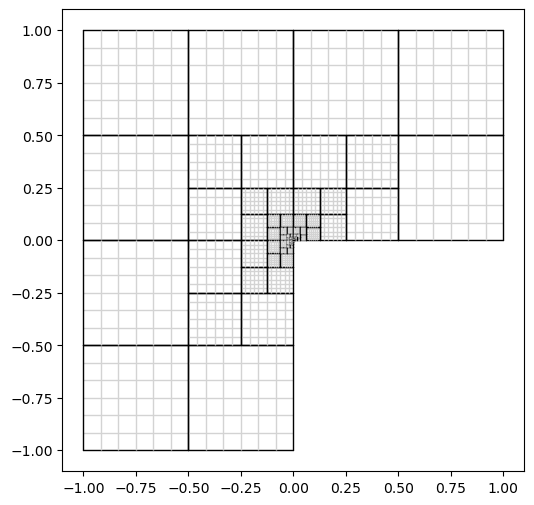

Residual contributions took 0.9743211269378662 seconds.
Jump contributions took 1.962883472442627 seconds.
Estimate and Marking took 2.9375360012054443 seconds.
Refinement took 0.04114484786987305 seconds.

19


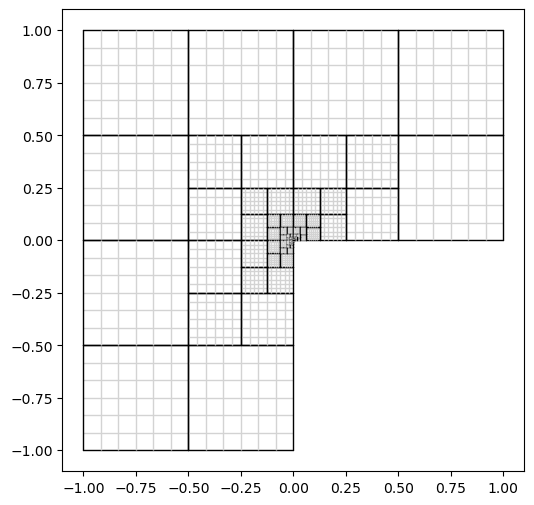

Residual contributions took 1.0320172309875488 seconds.
Jump contributions took 2.0723562240600586 seconds.
Estimate and Marking took 3.1050095558166504 seconds.
Refinement took 0.04282999038696289 seconds.

20


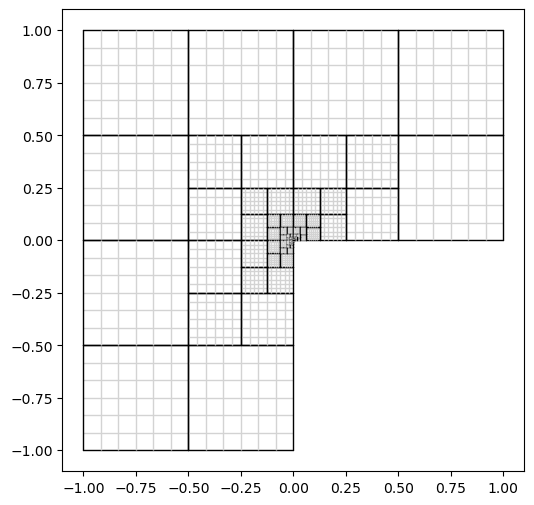

Residual contributions took 1.0802640914916992 seconds.
Jump contributions took 2.1813647747039795 seconds.
Estimate and Marking took 3.2622628211975098 seconds.
Refinement took 0.04430842399597168 seconds.

21


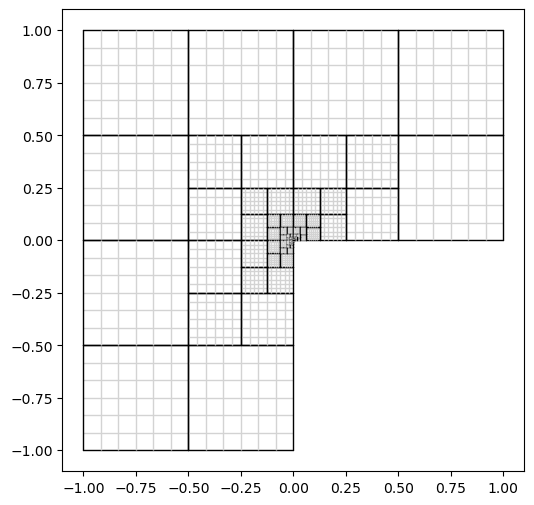

Residual contributions took 1.151296854019165 seconds.
Jump contributions took 2.3118057250976562 seconds.
Estimate and Marking took 3.4636895656585693 seconds.
Refinement took 0.04658198356628418 seconds.

22


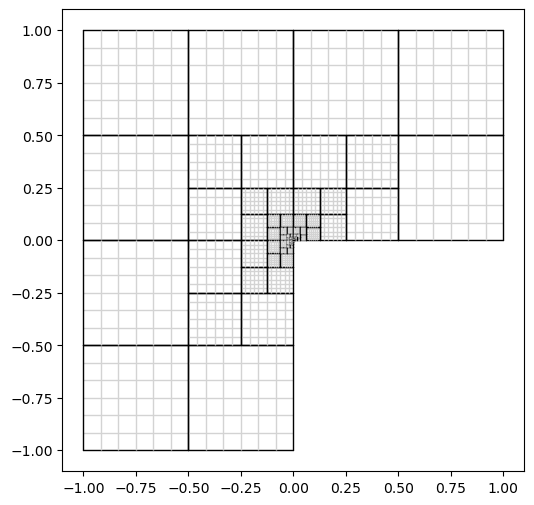

Residual contributions took 1.1936590671539307 seconds.
Jump contributions took 2.389366626739502 seconds.
Estimate and Marking took 3.583538293838501 seconds.
Refinement took 0.04828691482543945 seconds.

23


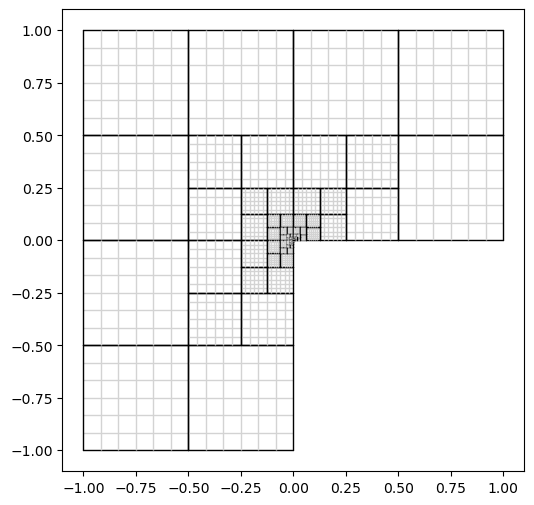

Residual contributions took 1.2380149364471436 seconds.
Jump contributions took 2.493964433670044 seconds.
Estimate and Marking took 3.732490062713623 seconds.
Refinement took 0.05000877380371094 seconds.

24


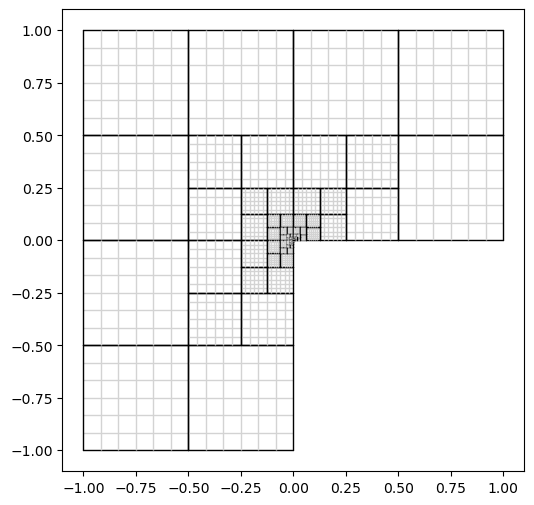

Residual contributions took 1.2949843406677246 seconds.
Jump contributions took 2.6017708778381348 seconds.
Estimate and Marking took 3.897312879562378 seconds.
Refinement took 0.10451602935791016 seconds.

25


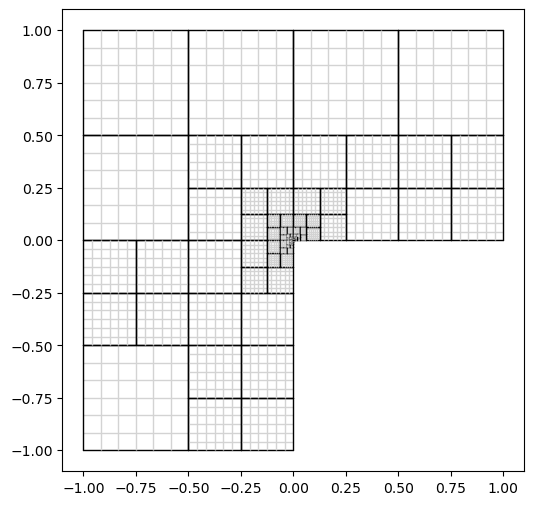

Residual contributions took 1.4290351867675781 seconds.
Jump contributions took 2.8175272941589355 seconds.
Estimate and Marking took 4.247268199920654 seconds.
Refinement took 0.15069031715393066 seconds.

26


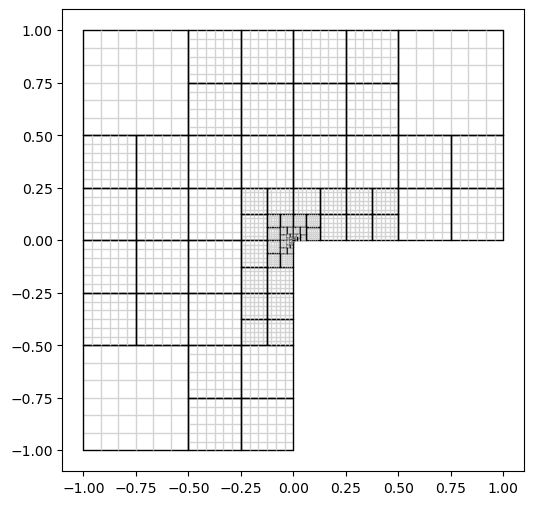

Residual contributions took 1.5390405654907227 seconds.
Jump contributions took 3.0879743099212646 seconds.
Estimate and Marking took 4.627741813659668 seconds.
Refinement took 0.16278862953186035 seconds.

27


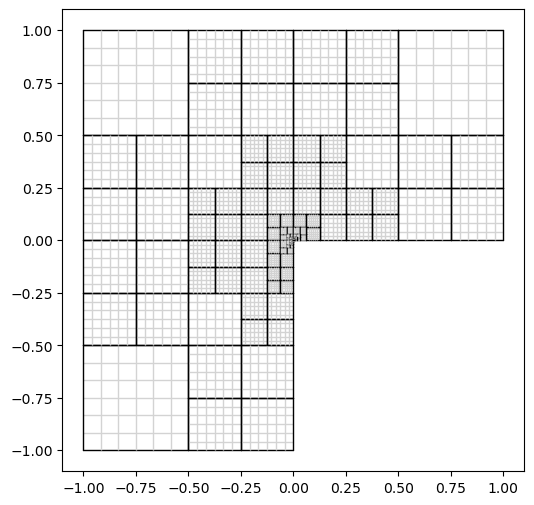

Residual contributions took 1.6996252536773682 seconds.
Jump contributions took 3.3774378299713135 seconds.
Estimate and Marking took 5.0778281688690186 seconds.
Refinement took 0.19524002075195312 seconds.

28


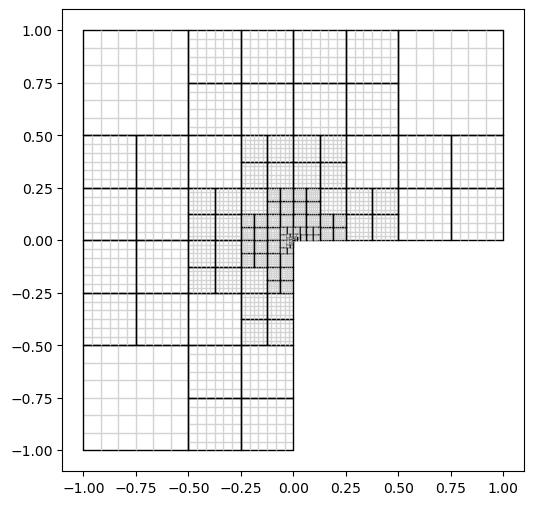

Residual contributions took 1.9226834774017334 seconds.
Jump contributions took 3.7013535499572754 seconds.
Estimate and Marking took 5.624844551086426 seconds.
Refinement took 0.23748064041137695 seconds.

29


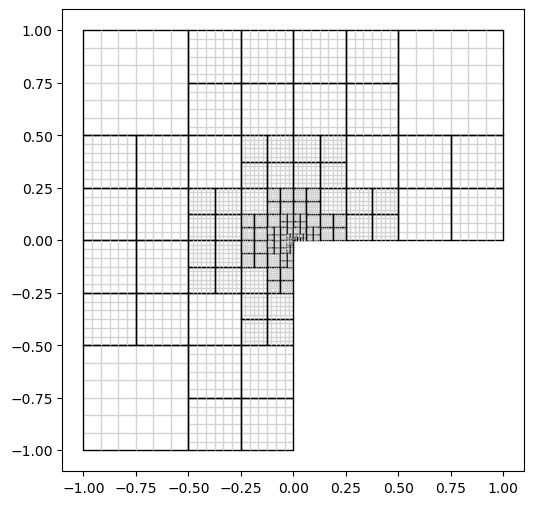

Residual contributions took 2.0779545307159424 seconds.
Jump contributions took 4.0454466342926025 seconds.
Estimate and Marking took 6.124182462692261 seconds.
Refinement took 0.3082160949707031 seconds.

30


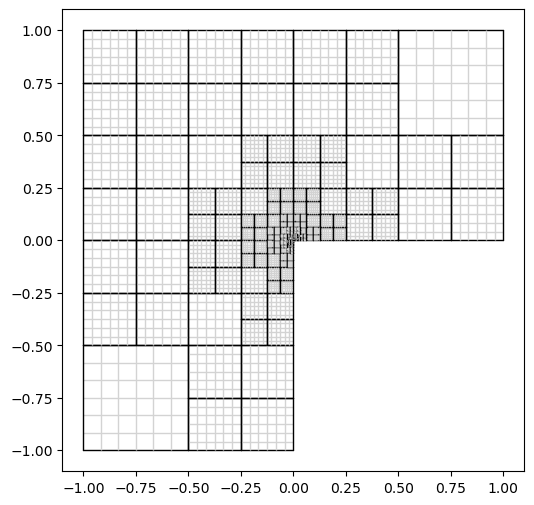

Residual contributions took 2.2969751358032227 seconds.
Jump contributions took 4.468055963516235 seconds.
Estimate and Marking took 6.7657225131988525 seconds.
Refinement took 0.38794732093811035 seconds.

31


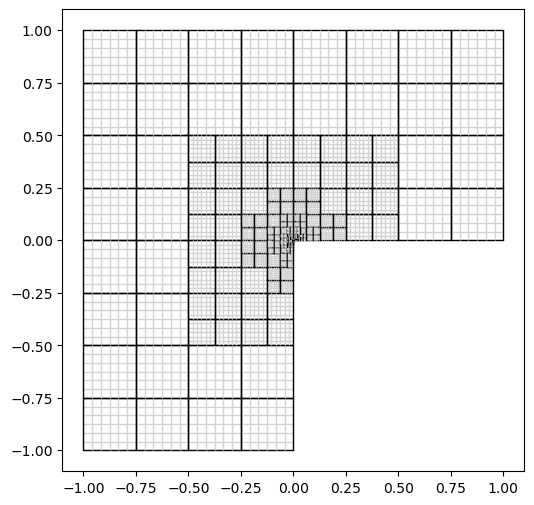

Residual contributions took 2.539006233215332 seconds.
Jump contributions took 4.937971115112305 seconds.
Estimate and Marking took 7.477818250656128 seconds.
Refinement took 0.39916396141052246 seconds.

32


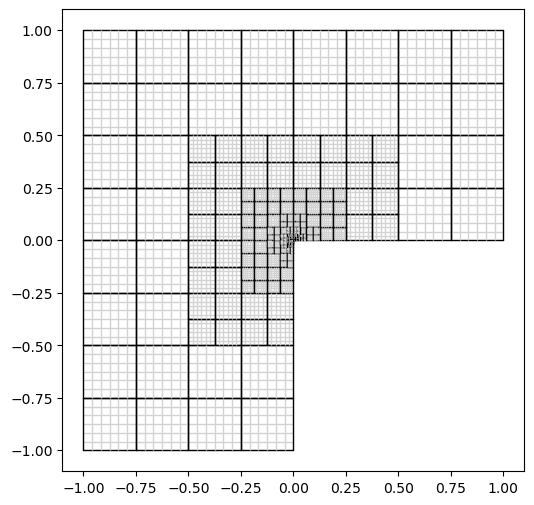

Residual contributions took 2.700526237487793 seconds.
Jump contributions took 5.356935024261475 seconds.
Estimate and Marking took 8.058354616165161 seconds.
Refinement took 0.5911860466003418 seconds.

33


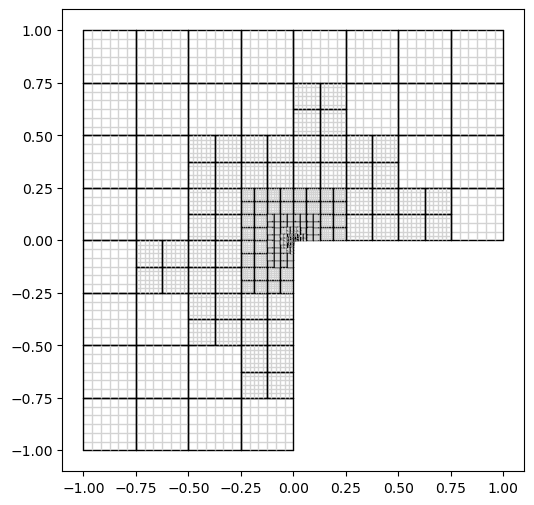

Residual contributions took 3.1105074882507324 seconds.
Jump contributions took 5.973886489868164 seconds.
Estimate and Marking took 9.085301399230957 seconds.
Refinement took 0.7581865787506104 seconds.

34


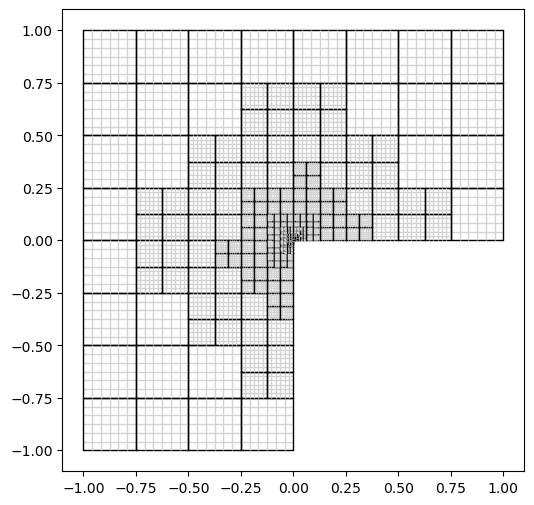

Residual contributions took 3.499021053314209 seconds.
Jump contributions took 6.683669805526733 seconds.
Estimate and Marking took 10.183677911758423 seconds.
Refinement took 1.0215559005737305 seconds.

35


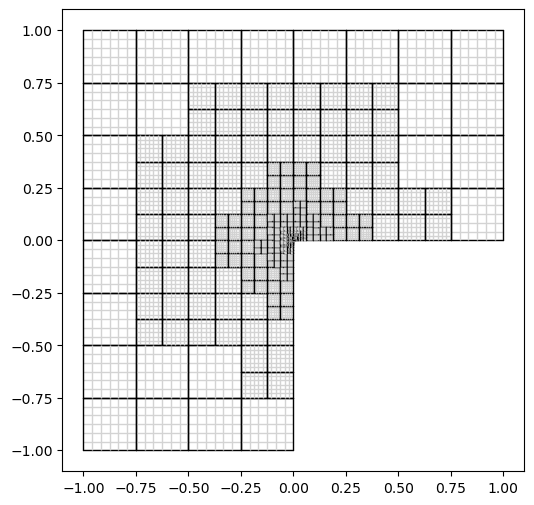

Residual contributions took 4.000831365585327 seconds.
Jump contributions took 7.573660850524902 seconds.
Estimate and Marking took 11.575417280197144 seconds.
Refinement took 1.2126832008361816 seconds.

36


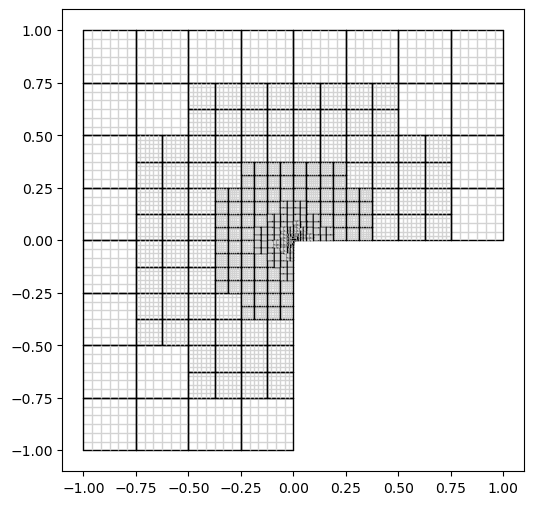

Residual contributions took 4.533814191818237 seconds.
Jump contributions took 8.487552881240845 seconds.
Estimate and Marking took 13.022390365600586 seconds.
Refinement took 1.7178239822387695 seconds.

37


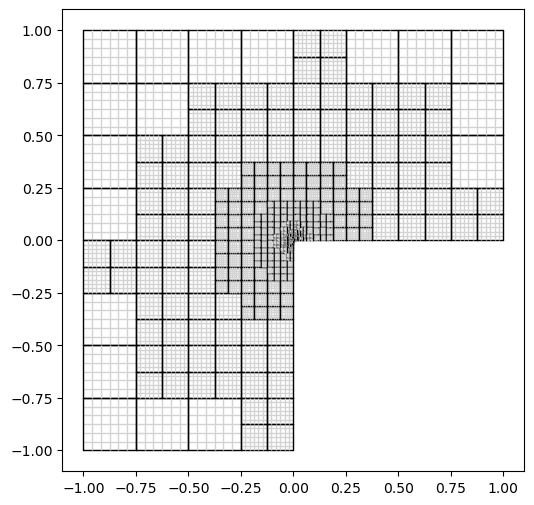

Residual contributions took 5.112687826156616 seconds.
Jump contributions took 9.702926397323608 seconds.
Estimate and Marking took 14.816833972930908 seconds.
Refinement took 2.2562379837036133 seconds.

38


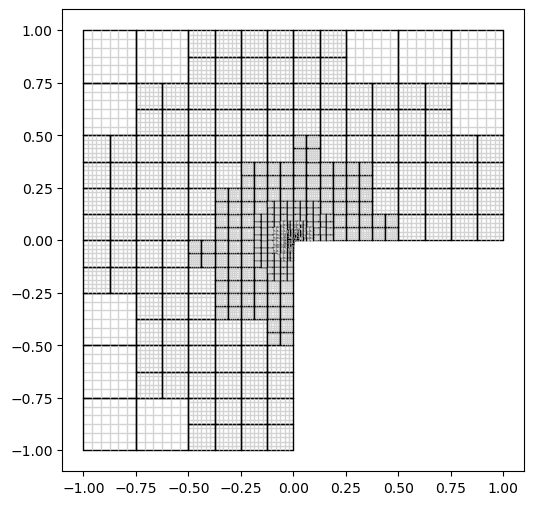

Residual contributions took 5.924292087554932 seconds.
Jump contributions took 11.014712572097778 seconds.
Estimate and Marking took 16.940306663513184 seconds.
Refinement took 2.9424078464508057 seconds.

39


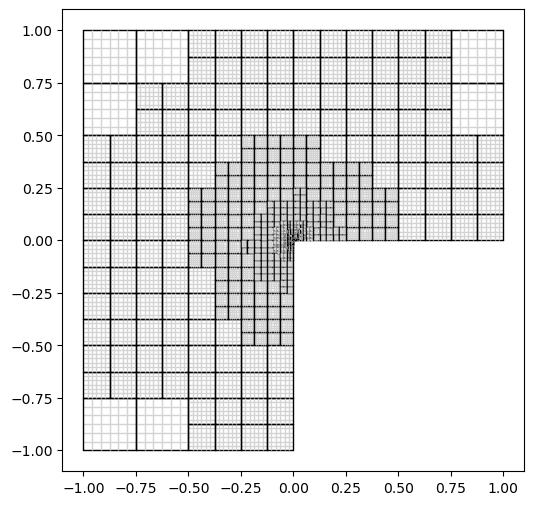

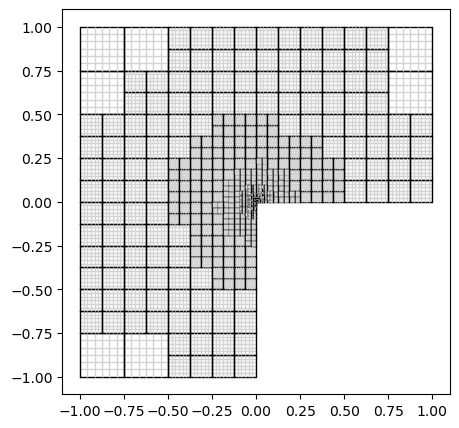

In [12]:
deg=5
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=40)
M.draw()

In [28]:
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp2n3.txt').reshape((4,23))

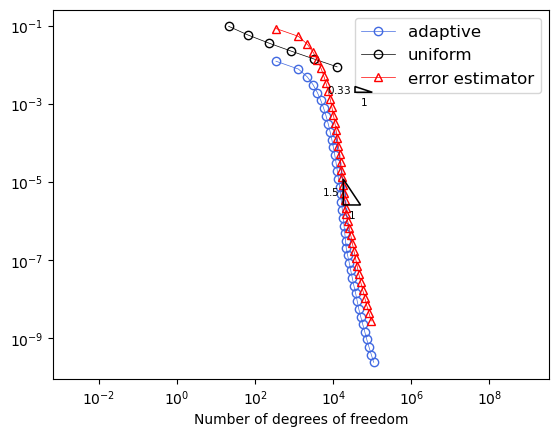

In [13]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(3/2) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,2.6*1e-6),2,1.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.2*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('equal');
plt.show()

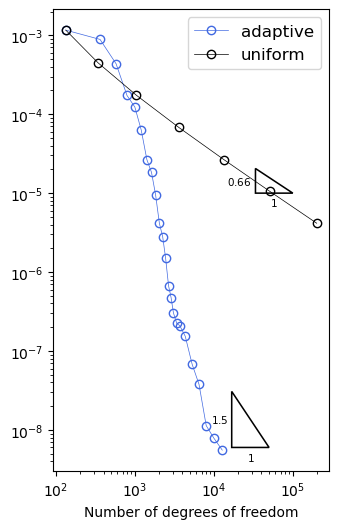

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,0.6*1e-8),2,slope=1.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.1*1e-4),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

0
Refinement took 0.00016999244689941406 seconds.
1
Refinement took 0.00015163421630859375 seconds.
2
Refinement took 0.00015091896057128906 seconds.
3
Refinement took 0.00020194053649902344 seconds.
4
Refinement took 0.00019550323486328125 seconds.
5
Refinement took 0.00024199485778808594 seconds.
6
Refinement took 0.012154817581176758 seconds.
7


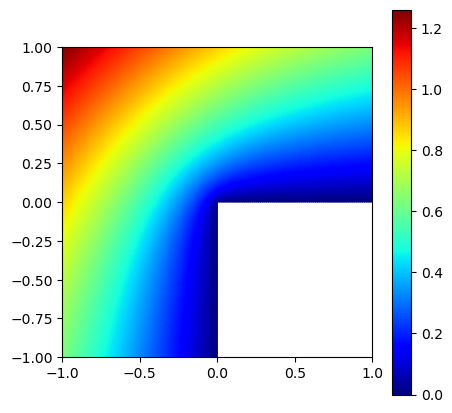

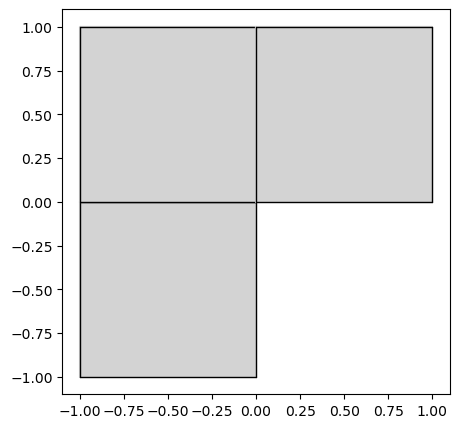

In [8]:
M = Lshape(3,4)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=8, draw=False)
M.draw()

0


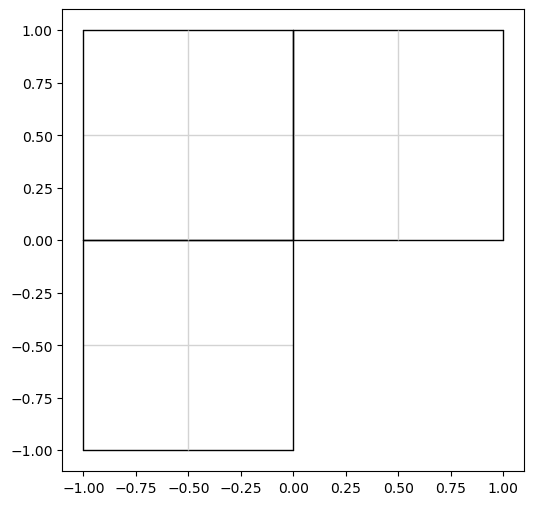

Residual contributions took 0.01932501792907715 seconds.
Jump contributions took 0.012791156768798828 seconds.
Estimate and Marking took 0.032379150390625 seconds.
Refinement took 0.008445978164672852 seconds.

1


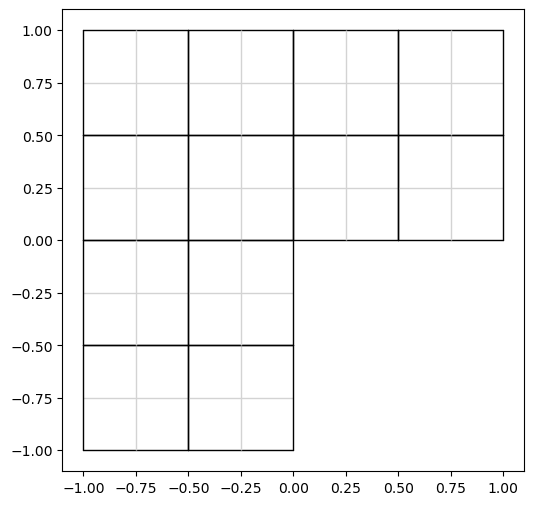

Residual contributions took 0.07642316818237305 seconds.
Jump contributions took 0.10577940940856934 seconds.
Estimate and Marking took 0.182356595993042 seconds.
Refinement took 0.010116100311279297 seconds.

2


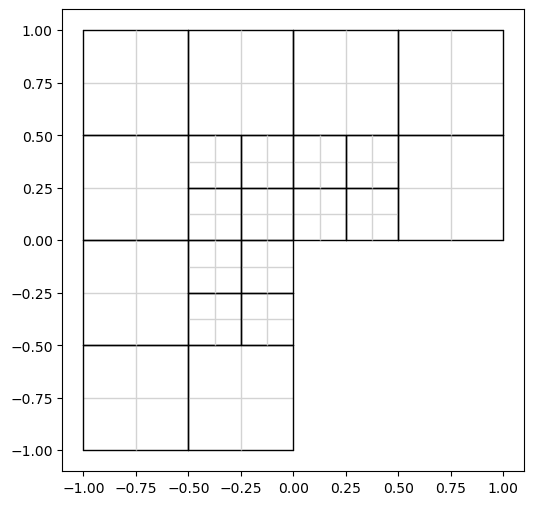

Residual contributions took 0.1349177360534668 seconds.
Jump contributions took 0.23641443252563477 seconds.
Estimate and Marking took 0.3715066909790039 seconds.
Refinement took 0.012928962707519531 seconds.

3


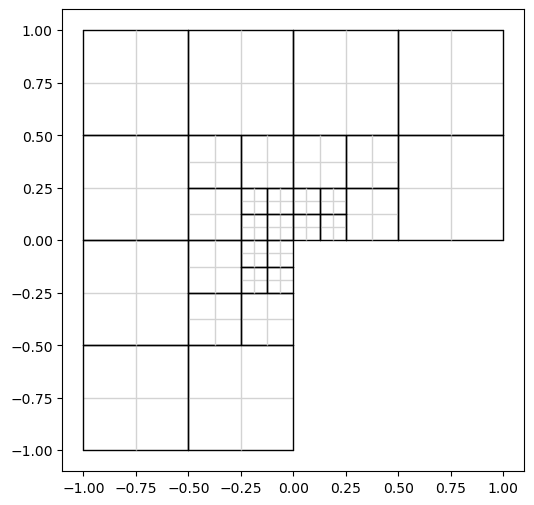

Residual contributions took 0.1842794418334961 seconds.
Jump contributions took 0.3697943687438965 seconds.
Estimate and Marking took 0.5544044971466064 seconds.
Refinement took 0.05284285545349121 seconds.

4


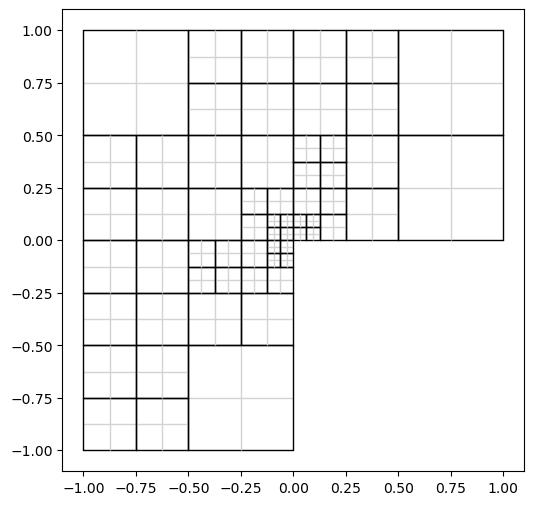

Residual contributions took 0.37060093879699707 seconds.
Jump contributions took 1.1677441596984863 seconds.
Estimate and Marking took 1.5390293598175049 seconds.
Refinement took 0.17905449867248535 seconds.

5


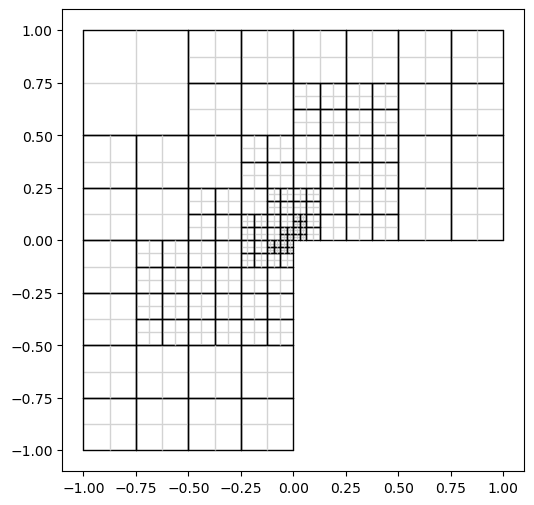

Residual contributions took 0.7649221420288086 seconds.
Jump contributions took 1.6732230186462402 seconds.
Estimate and Marking took 2.4388270378112793 seconds.
Refinement took 0.7045743465423584 seconds.

6


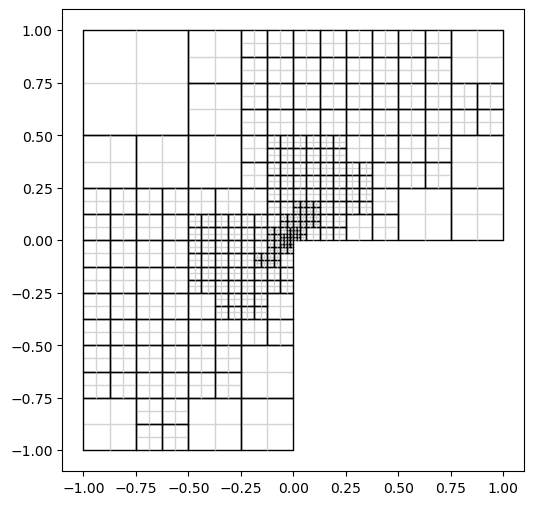

Residual contributions took 1.6600542068481445 seconds.
Jump contributions took 3.678410530090332 seconds.
Estimate and Marking took 5.339890241622925 seconds.
Refinement took 3.1724460124969482 seconds.

7


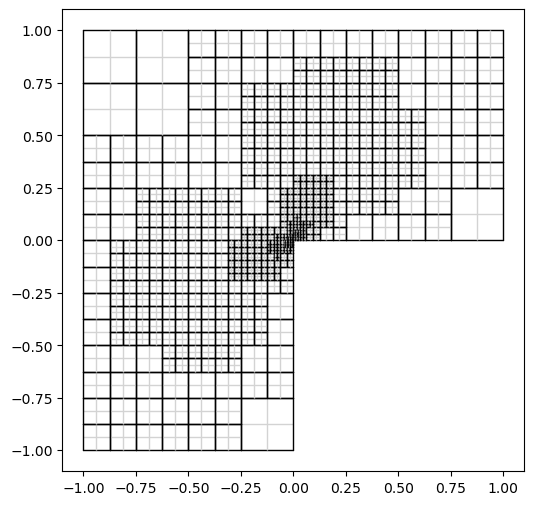

Residual contributions took 3.643850326538086 seconds.
Jump contributions took 8.526892185211182 seconds.
Estimate and Marking took 12.173875570297241 seconds.
Refinement took 13.930756568908691 seconds.

8


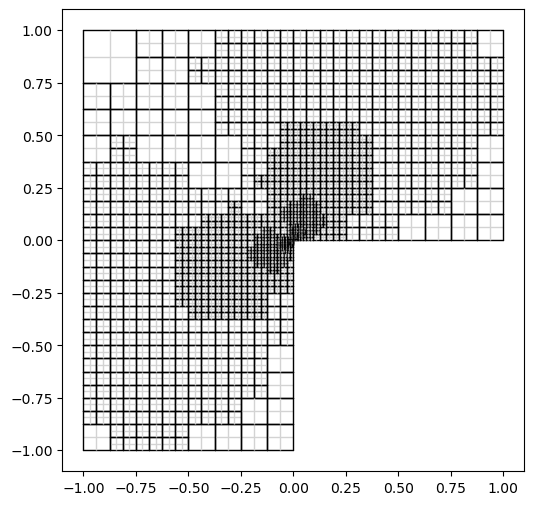

Residual contributions took 7.934520721435547 seconds.
Jump contributions took 18.304932355880737 seconds.
Estimate and Marking took 26.25003933906555 seconds.
Refinement took 68.8877694606781 seconds.

9


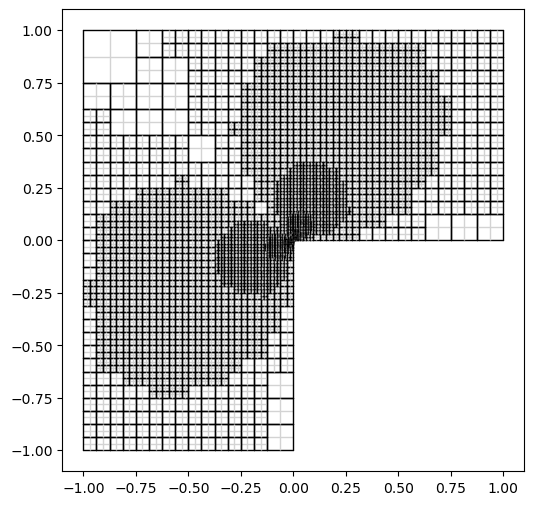

KeyboardInterrupt: 

In [22]:
M = Lshape(1,2)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=12)
M.draw()

In [207]:
np.savetxt('Lp3n4.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

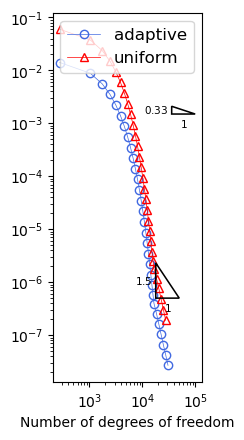

In [21]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,0.5*1e-6),2,1.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.15*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

In [8]:
np.where(err_ind[-1]>1e-4)[0]

array([  4,  30,  39, 142, 174, 175, 176, 232, 233, 264, 277, 382, 558, 559, 560, 579, 580, 581])

In [9]:
{0:set(list(np.where(err_ind[-1]>1e-4)[0]))}

{0: {4,
  30,
  39,
  142,
  174,
  175,
  176,
  232,
  233,
  264,
  277,
  382,
  558,
  559,
  560,
  579,
  580,
  581}}

In [10]:
MP_a.mesh.set_domain_id({1:set(list(np.where(err_ind[-1]>1e-4)[0]))})

In [11]:
MP_a.mesh.domains[1]

{4,
 30,
 39,
 142,
 174,
 175,
 176,
 232,
 233,
 264,
 277,
 382,
 558,
 559,
 560,
 579,
 580,
 581}

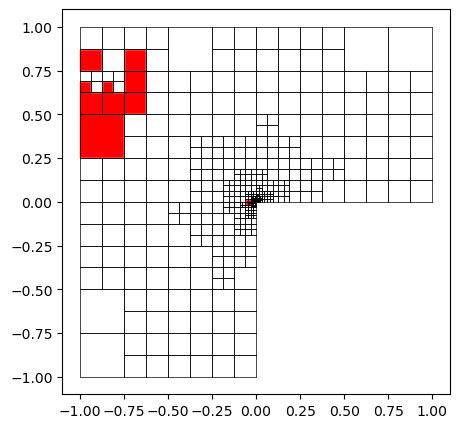

In [18]:
MP_a.mesh.draw(knots=False, color={0:'white',1:'red'}, bwidth=0.5)

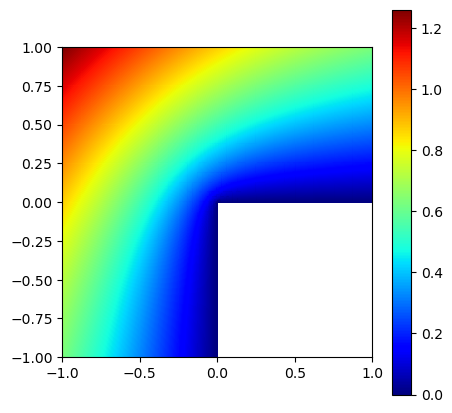

In [15]:
MP_a.plot(uh_a)

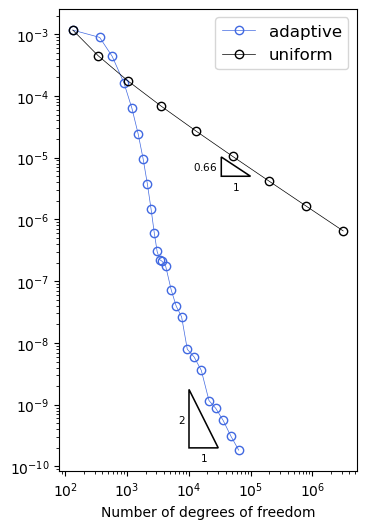

In [240]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.3*1e5,0.2*1e-9),2,slope=2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.05*1e-4),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

In [254]:
M = Lshape(4,5)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=9, draw=False)
M.draw()

0
Refinement took 0.00015354156494140625 seconds.
1
Refinement took 0.00023245811462402344 seconds.
2
Refinement took 0.00025272369384765625 seconds.
3
Refinement took 0.0002415180206298828 seconds.
4
Refinement took 0.0002295970916748047 seconds.
5
Refinement took 0.0003037452697753906 seconds.
6
Refinement took 0.00034165382385253906 seconds.
7
Refinement took 0.0005028247833251953 seconds.
8


CholmodTooLargeError: ../Supernodal/cholmod_super_symbolic.c:683: problem too large (code -3)

1
0


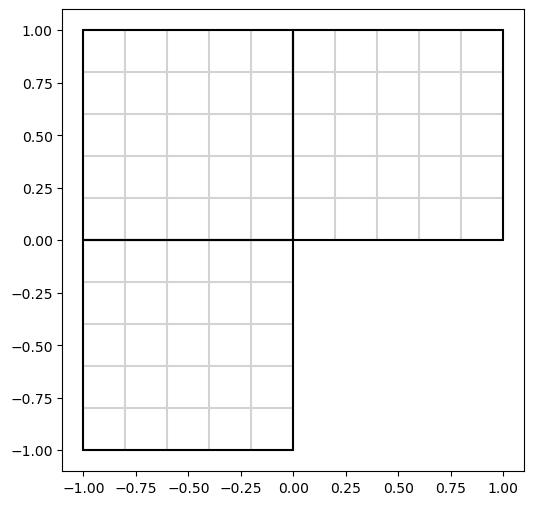

Residual contributions took 0.020650625228881836 seconds.
Jump contributions took 0.01316690444946289 seconds.
Estimate and Marking took 0.03397250175476074 seconds.
Refinement took 0.008510351181030273 seconds.

1


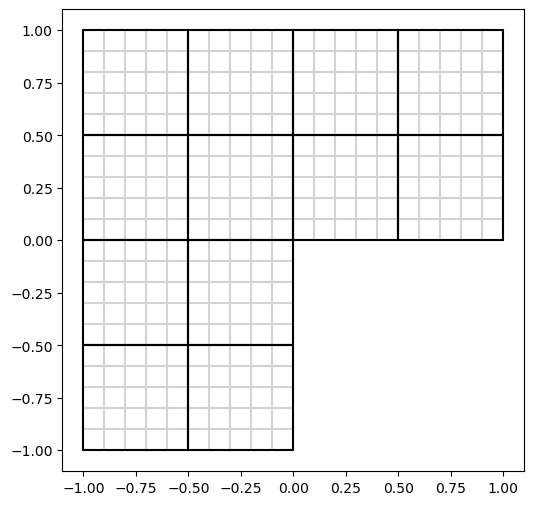

Residual contributions took 0.07957124710083008 seconds.
Jump contributions took 0.1064291000366211 seconds.
Estimate and Marking took 0.18616127967834473 seconds.
Refinement took 0.010097503662109375 seconds.

2


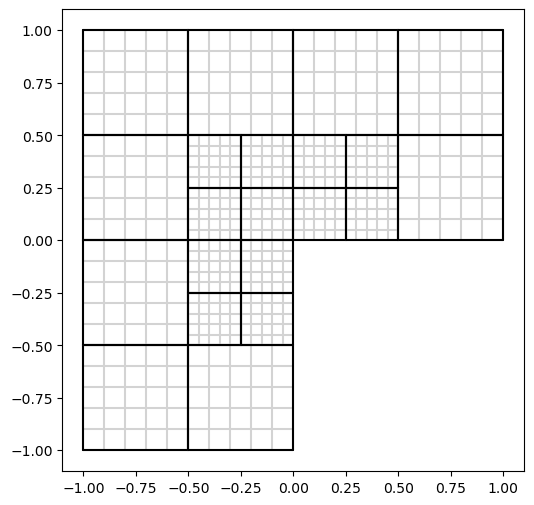

Residual contributions took 0.12996864318847656 seconds.
Jump contributions took 0.2387995719909668 seconds.
Estimate and Marking took 0.36931467056274414 seconds.
Refinement took 0.012935400009155273 seconds.

3


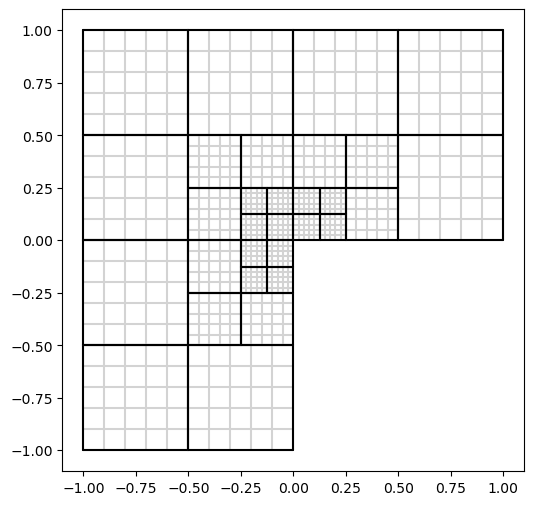

Residual contributions took 0.18905401229858398 seconds.
Jump contributions took 0.3822367191314697 seconds.
Estimate and Marking took 0.5717771053314209 seconds.
Refinement took 0.014523983001708984 seconds.

4


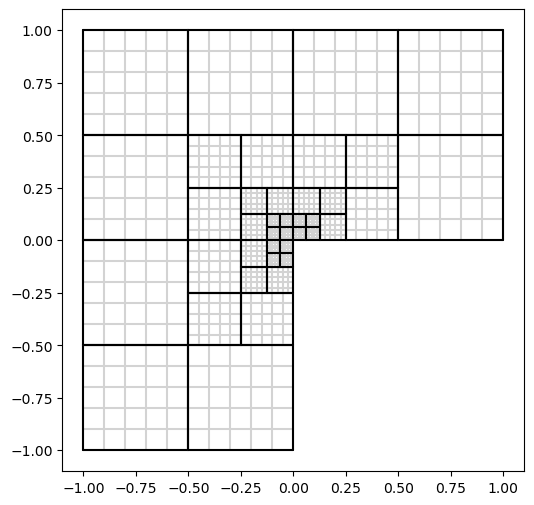

Residual contributions took 0.251096248626709 seconds.
Jump contributions took 0.5257279872894287 seconds.
Estimate and Marking took 0.7770850658416748 seconds.
Refinement took 0.0166318416595459 seconds.

5


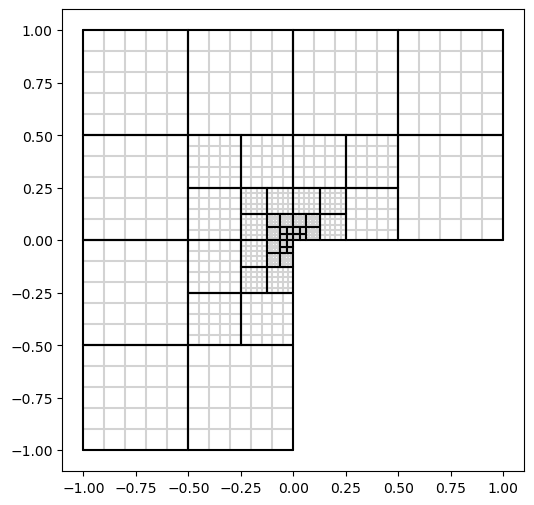

Residual contributions took 0.29926371574401855 seconds.
Jump contributions took 0.6569766998291016 seconds.
Estimate and Marking took 0.9567971229553223 seconds.
Refinement took 0.01838231086730957 seconds.

6


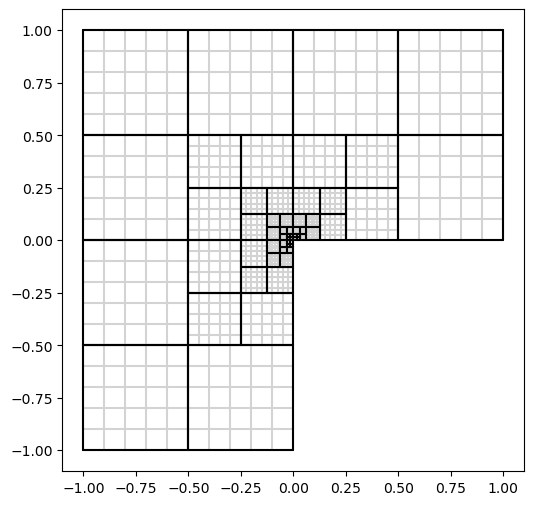

Residual contributions took 0.35369062423706055 seconds.
Jump contributions took 0.7919135093688965 seconds.
Estimate and Marking took 1.1462559700012207 seconds.
Refinement took 0.020965099334716797 seconds.

7


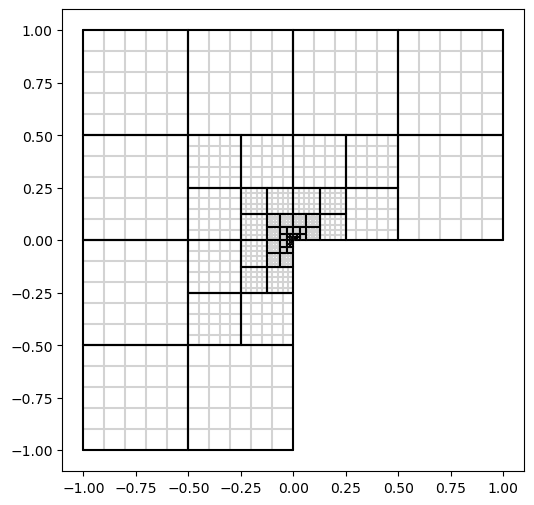

Residual contributions took 0.4075958728790283 seconds.
Jump contributions took 0.9308862686157227 seconds.
Estimate and Marking took 1.3387622833251953 seconds.
Refinement took 0.022440195083618164 seconds.

8


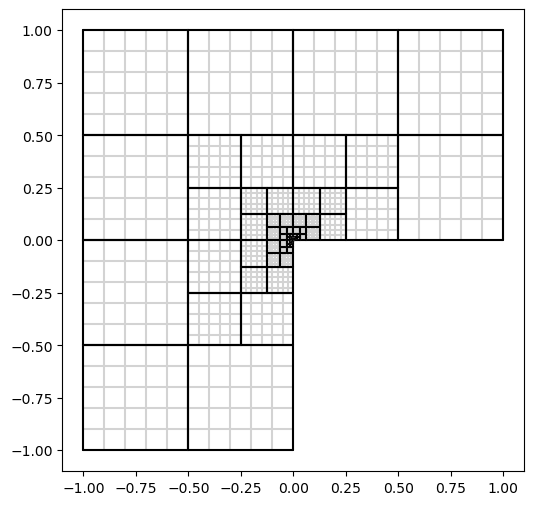

Residual contributions took 0.46224045753479004 seconds.
Jump contributions took 1.068678855895996 seconds.
Estimate and Marking took 1.5311858654022217 seconds.
Refinement took 0.02449512481689453 seconds.

9


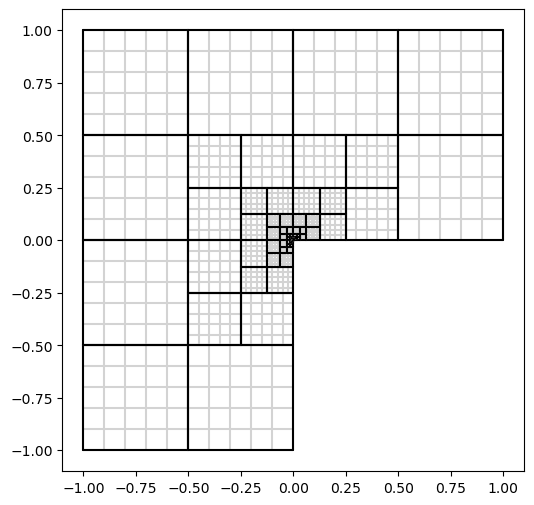

Residual contributions took 0.5285191535949707 seconds.
Jump contributions took 1.2115461826324463 seconds.
Estimate and Marking took 1.7403669357299805 seconds.
Refinement took 0.02652430534362793 seconds.

10


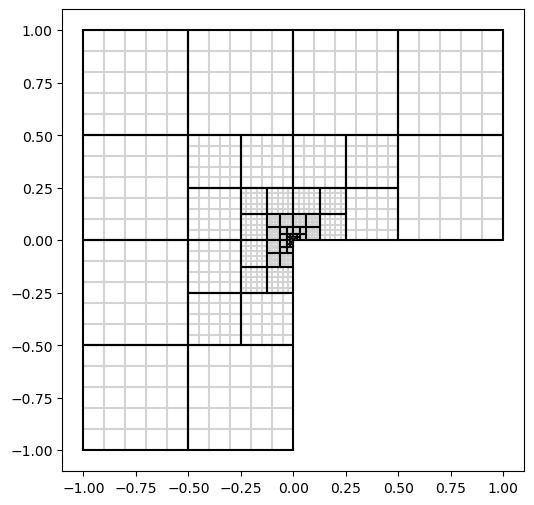

Residual contributions took 0.5951464176177979 seconds.
Jump contributions took 1.3445188999176025 seconds.
Estimate and Marking took 1.9399526119232178 seconds.
Refinement took 0.028524398803710938 seconds.

11


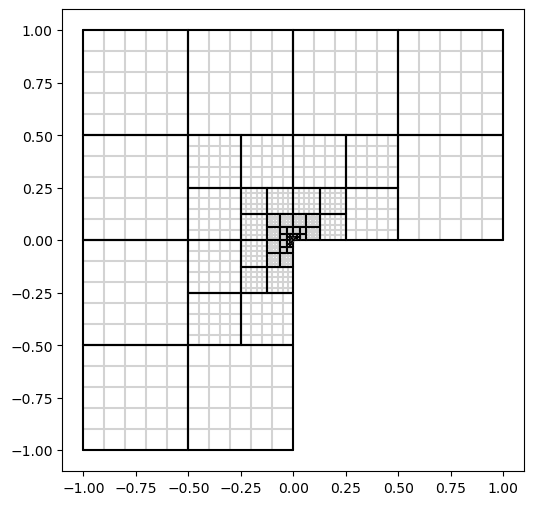

Residual contributions took 0.6461341381072998 seconds.
Jump contributions took 1.5015122890472412 seconds.
Estimate and Marking took 2.147982120513916 seconds.
Refinement took 0.03111743927001953 seconds.

12


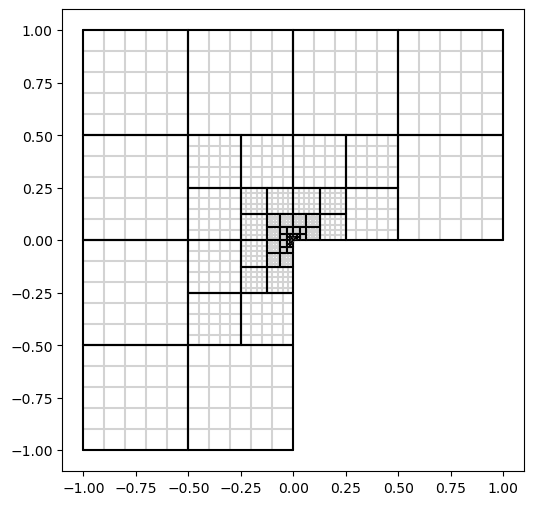

Residual contributions took 0.6992189884185791 seconds.
Jump contributions took 1.6154370307922363 seconds.
Estimate and Marking took 2.315001964569092 seconds.
Refinement took 0.033327579498291016 seconds.

13


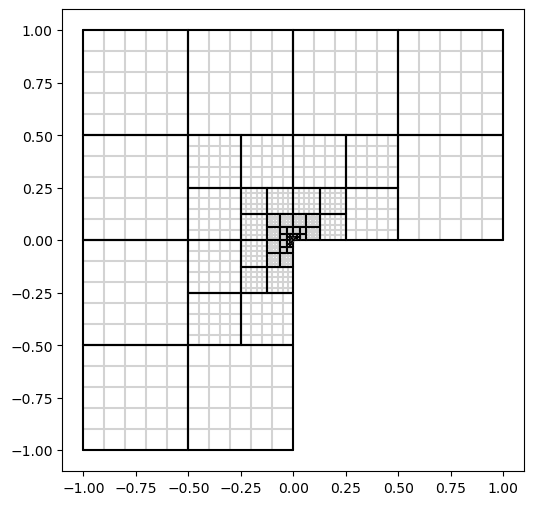

Residual contributions took 0.754000186920166 seconds.
Jump contributions took 1.8550689220428467 seconds.
Estimate and Marking took 2.6095712184906006 seconds.
Refinement took 0.03667092323303223 seconds.

14


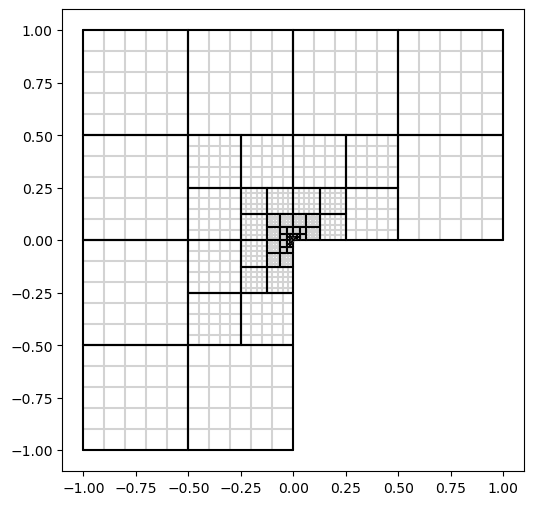

Residual contributions took 0.8244433403015137 seconds.
Jump contributions took 1.8870387077331543 seconds.
Estimate and Marking took 2.7118189334869385 seconds.
Refinement took 0.03613710403442383 seconds.

15


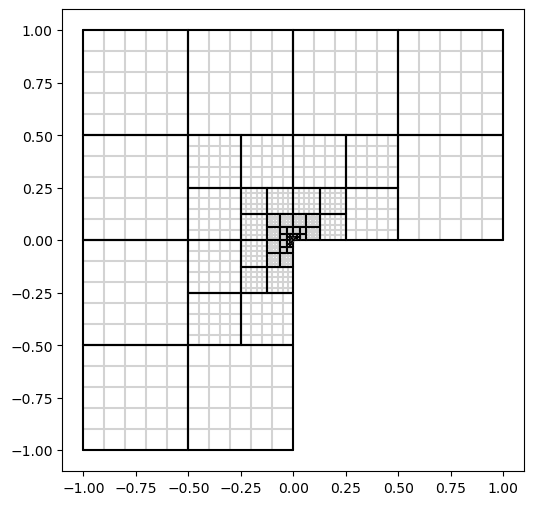

Residual contributions took 0.8810679912567139 seconds.
Jump contributions took 2.0233020782470703 seconds.
Estimate and Marking took 2.904675006866455 seconds.
Refinement took 0.038181304931640625 seconds.

16


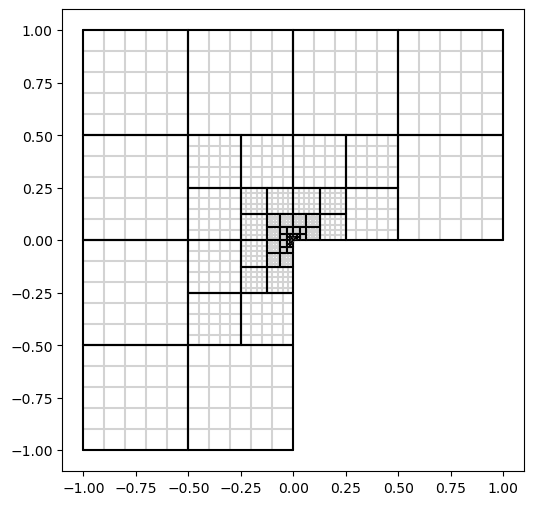

Residual contributions took 0.9142296314239502 seconds.
Jump contributions took 2.1654515266418457 seconds.
Estimate and Marking took 3.080293655395508 seconds.
Refinement took 0.03934741020202637 seconds.

17


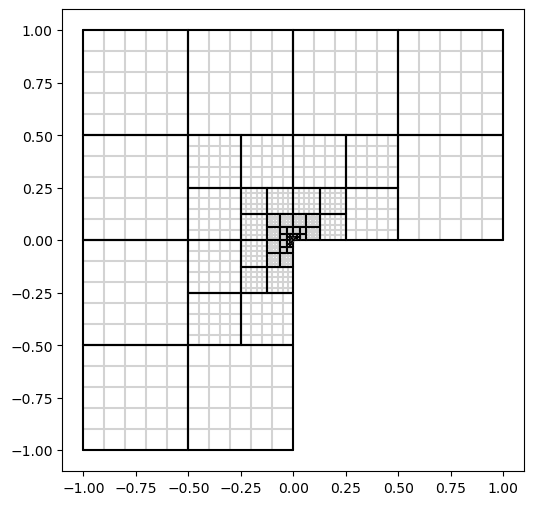

Residual contributions took 0.9691939353942871 seconds.
Jump contributions took 2.2867026329040527 seconds.
Estimate and Marking took 3.2562203407287598 seconds.
Refinement took 0.04179501533508301 seconds.

18


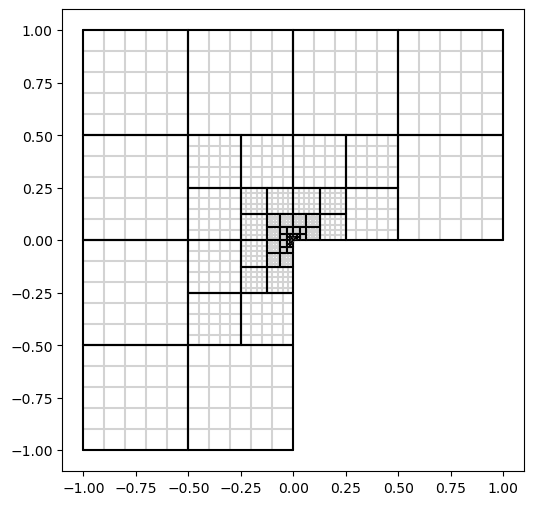

Residual contributions took 1.089613676071167 seconds.
Jump contributions took 2.4318230152130127 seconds.
Estimate and Marking took 3.5217721462249756 seconds.
Refinement took 0.04396820068359375 seconds.

19


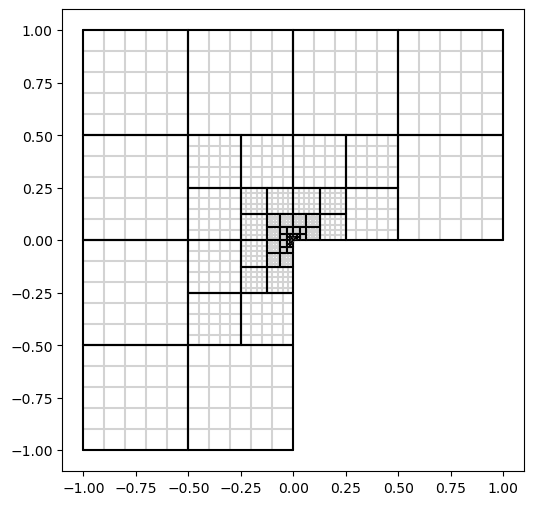

Residual contributions took 1.0806043148040771 seconds.
Jump contributions took 2.568394184112549 seconds.
Estimate and Marking took 3.6493570804595947 seconds.
Refinement took 0.04547739028930664 seconds.

20


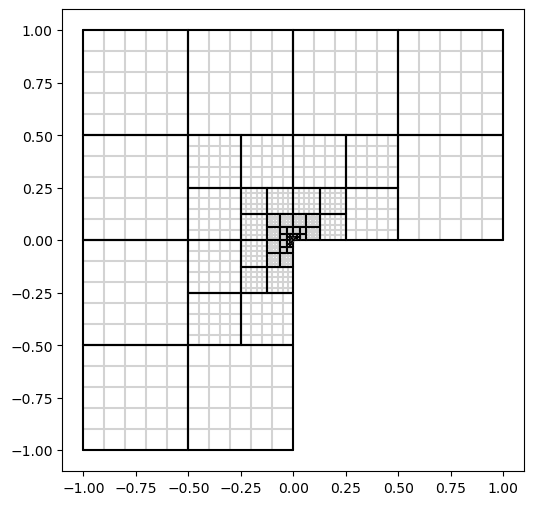

Residual contributions took 1.1512367725372314 seconds.
Jump contributions took 2.7180354595184326 seconds.
Estimate and Marking took 3.8699443340301514 seconds.
Refinement took 0.049156904220581055 seconds.

21


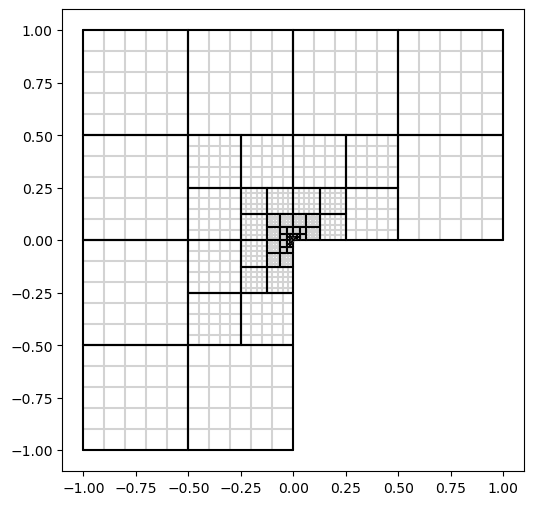

Residual contributions took 1.216332197189331 seconds.
Jump contributions took 2.837141990661621 seconds.
Estimate and Marking took 4.054126024246216 seconds.
Refinement took 0.0488736629486084 seconds.

22


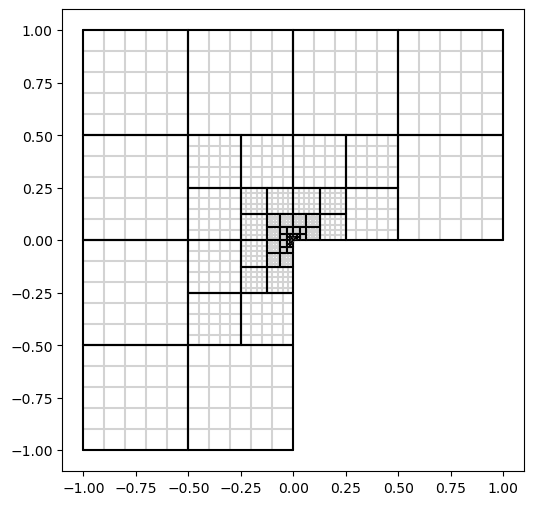

Residual contributions took 1.2893986701965332 seconds.
Jump contributions took 2.9841086864471436 seconds.
Estimate and Marking took 4.2741944789886475 seconds.
Refinement took 0.13922452926635742 seconds.

23


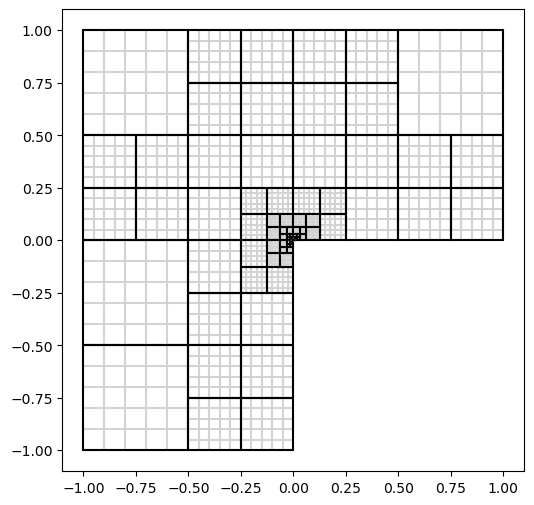

Residual contributions took 1.4448025226593018 seconds.
Jump contributions took 3.301848888397217 seconds.
Estimate and Marking took 4.747355699539185 seconds.
Refinement took 0.17220139503479004 seconds.

24


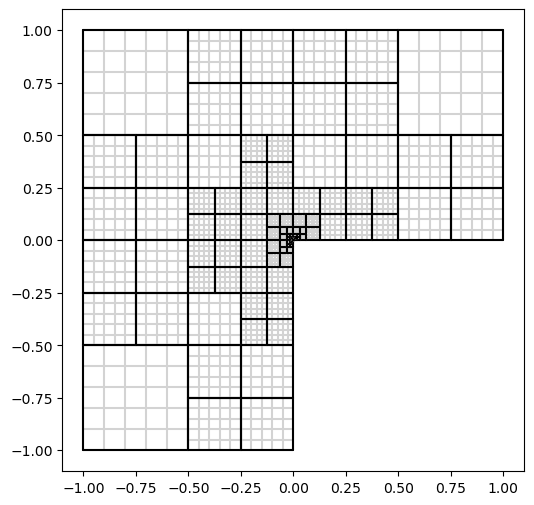

Residual contributions took 1.6307411193847656 seconds.
Jump contributions took 3.731083393096924 seconds.
Estimate and Marking took 5.3625500202178955 seconds.
Refinement took 0.1875300407409668 seconds.

25


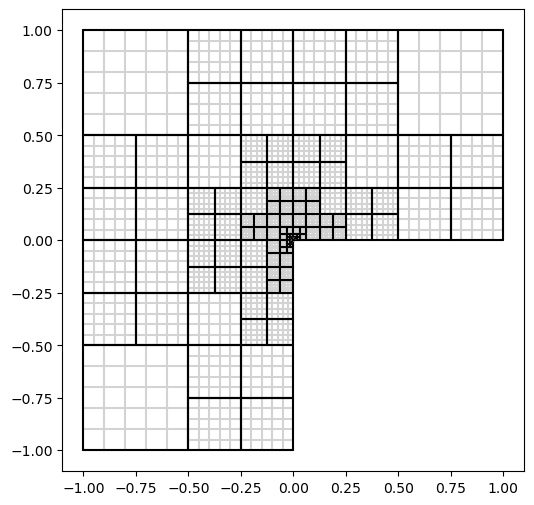

Residual contributions took 1.823732614517212 seconds.
Jump contributions took 4.172735214233398 seconds.
Estimate and Marking took 5.99726128578186 seconds.
Refinement took 0.27751755714416504 seconds.

26


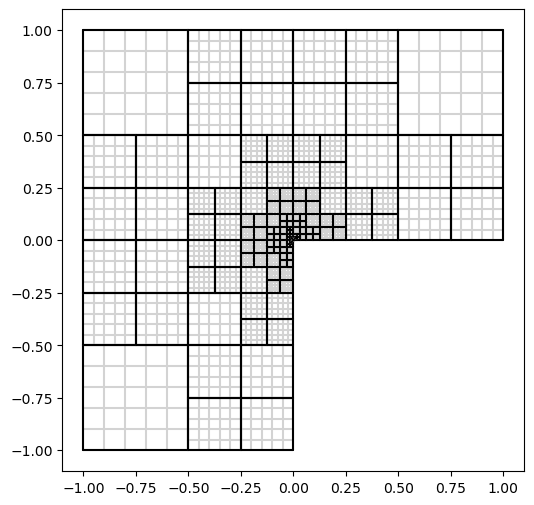

Residual contributions took 1.9895284175872803 seconds.
Jump contributions took 4.591368198394775 seconds.
Estimate and Marking took 6.581641674041748 seconds.
Refinement took 0.3281745910644531 seconds.

27


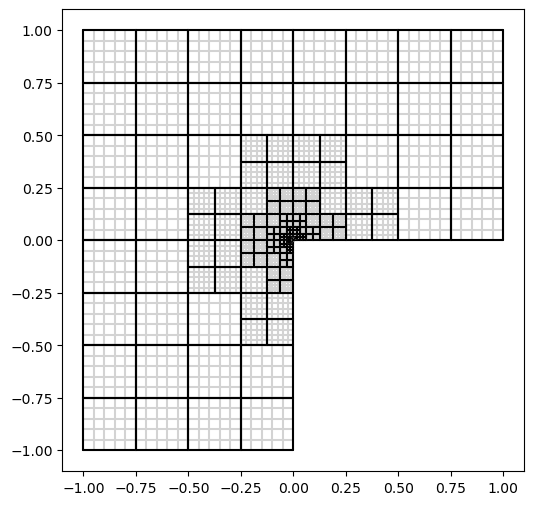

Residual contributions took 2.253469944000244 seconds.
Jump contributions took 5.077566862106323 seconds.
Estimate and Marking took 7.331822156906128 seconds.
Refinement took 0.38580870628356934 seconds.

28


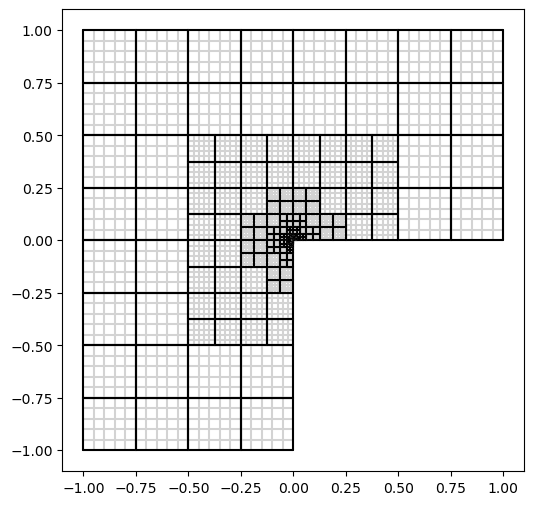

Residual contributions took 2.5291805267333984 seconds.
Jump contributions took 5.6715781688690186 seconds.
Estimate and Marking took 8.201542615890503 seconds.
Refinement took 0.5844552516937256 seconds.

29


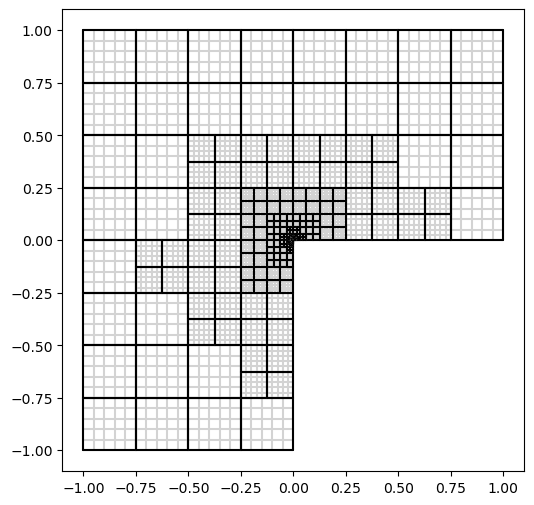

Residual contributions took 2.844757556915283 seconds.
Jump contributions took 6.514358758926392 seconds.
Estimate and Marking took 9.359963417053223 seconds.
Refinement took 0.819124698638916 seconds.

30


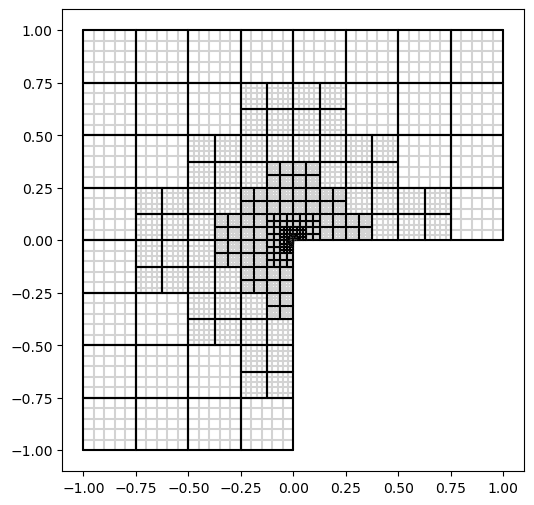

Residual contributions took 3.3619184494018555 seconds.
Jump contributions took 7.557915687561035 seconds.
Estimate and Marking took 10.920750141143799 seconds.
Refinement took 1.13356351852417 seconds.

31


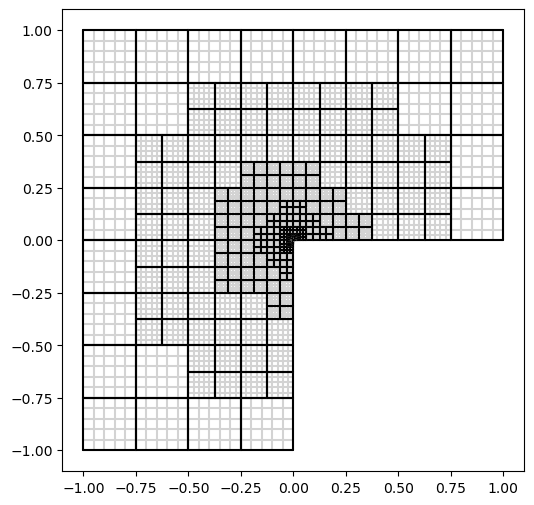

Residual contributions took 3.877429246902466 seconds.
Jump contributions took 8.764891624450684 seconds.
Estimate and Marking took 12.643351316452026 seconds.
Refinement took 1.6046726703643799 seconds.

32


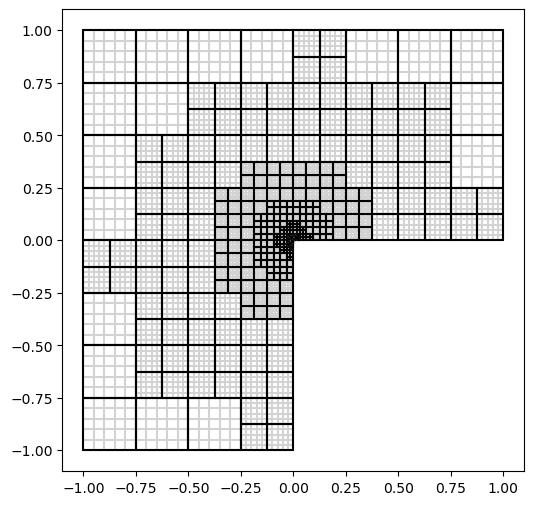

Residual contributions took 4.574916362762451 seconds.
Jump contributions took 10.277218580245972 seconds.
Estimate and Marking took 14.853216648101807 seconds.
Refinement took 2.3057212829589844 seconds.

33


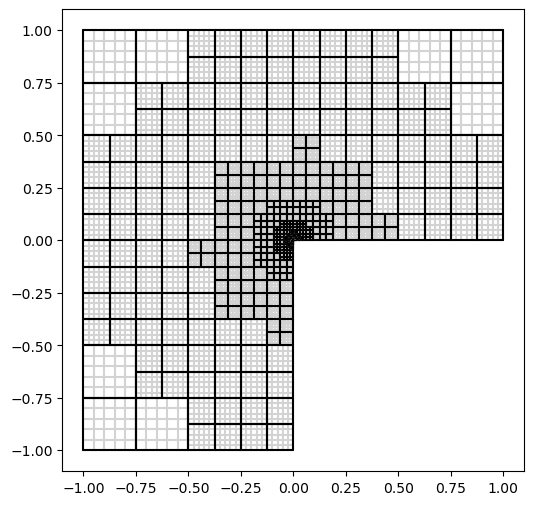

Residual contributions took 5.481000900268555 seconds.
Jump contributions took 12.132431745529175 seconds.
Estimate and Marking took 17.614620208740234 seconds.
Refinement took 2.848871946334839 seconds.

34


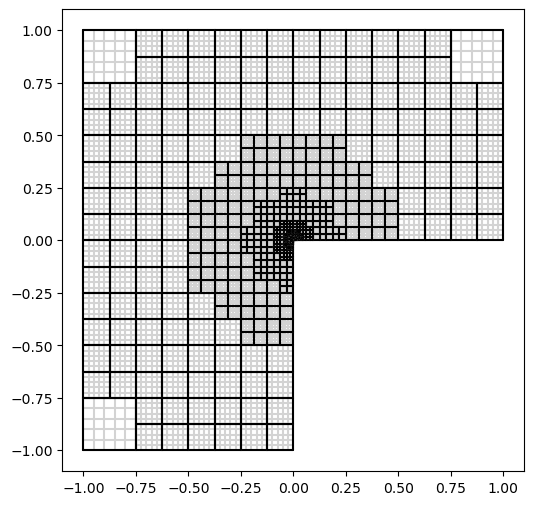

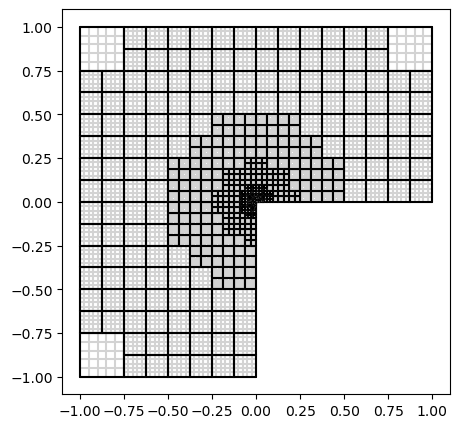

In [244]:
M = Lshape(4,5)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=35)
M.draw()

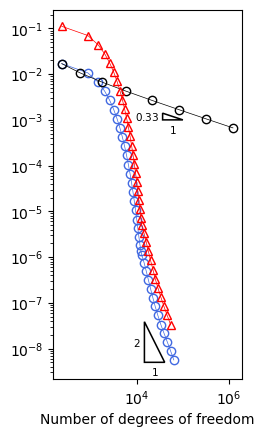

In [265]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.4*1e5,0.5*1e-8),2,2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.1*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

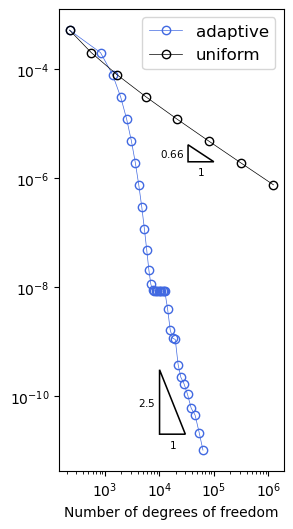

In [262]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.3*1e5,0.2*1e-10),2,slope=2.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.2*1e-5),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()